# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [158]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [159]:
sns.set_style("white")
plt.style.use("huddlej")

In [160]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [161]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [162]:
colors.reverse()

In [163]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [164]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI tree cross-immunity",
    "cTiterSub": "linear HI mutation phenotypes",
    "cTiterSub_star": "ancestral HI mutation phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mut effect",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [165]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [166]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df["validation_error"].min()
    max_normal_error = errors_by_time_df["validation_error"].max()

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    max_coefficient = coefficients_by_time_df["coefficient"].max()

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")
        distance_ax.set_ylim(-0.5, 0.8)
        distance_ax.text(
            0.025,
            0.9,
            "%s: %.2f +/- %.2f" % (composite_predictors_name, error_df["validation_error"].mean(), error_df["validation_error"].std()),
            fontdict={"fontsize": 12},
            transform=distance_ax.transAxes
        )

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        distance_ax.plot(
            pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_error_df["validation_error"],
            "o-",
            color="#cccccc",
            zorder=-10
        )

        distance_ax.plot(
            pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
            error_df["validation_error"],
            "o-",
            color="#000000"
        )

        distance_ax.set_xlim(min_date, max_date)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

        offset = 0.9
        for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):            
            coefficient_ax.text(
                0.035,
                offset,
                "%s: %.2f +/- %.2f" % (
                    name_by_predictor[individual_predictor],
                    individual_predictor_df["coefficient"].mean(),
                    individual_predictor_df["coefficient"].std()
                ),
                fontdict={"fontsize": 12},
                transform=coefficient_ax.transAxes
            )
            offset = offset - text_vertical_padding

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )
        
        for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor]
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')

    fig.autofmt_xdate(rotation=rotation)
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

## Load data

In [168]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_0_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [169]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [170]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [171]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3', 'natural_sample_0_with_90_vpm_sliding'],
      dtype=object)

In [172]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [173]:
simulated_errors_by_time_df.shape

(230, 6)

In [174]:
natural_errors_by_time_df.shape

(812, 6)

In [175]:
luksza_errors_by_time_df.shape

(0, 6)

In [176]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [177]:
simulated_coefficients_by_time_df.shape

(345, 6)

In [178]:
natural_coefficients_by_time_df.shape

(1334, 6)

In [179]:
luksza_coefficients_by_time_df.shape

(0, 6)

In [180]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [181]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_wolf',
 'ep_x',
 'rb',
 'cTiter',
 'cTiter_x',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'dms_nonepitope',
 'dms_entropy',
 'lbi',
 'delta_frequency']

## Distance to the future

### Simulated populations

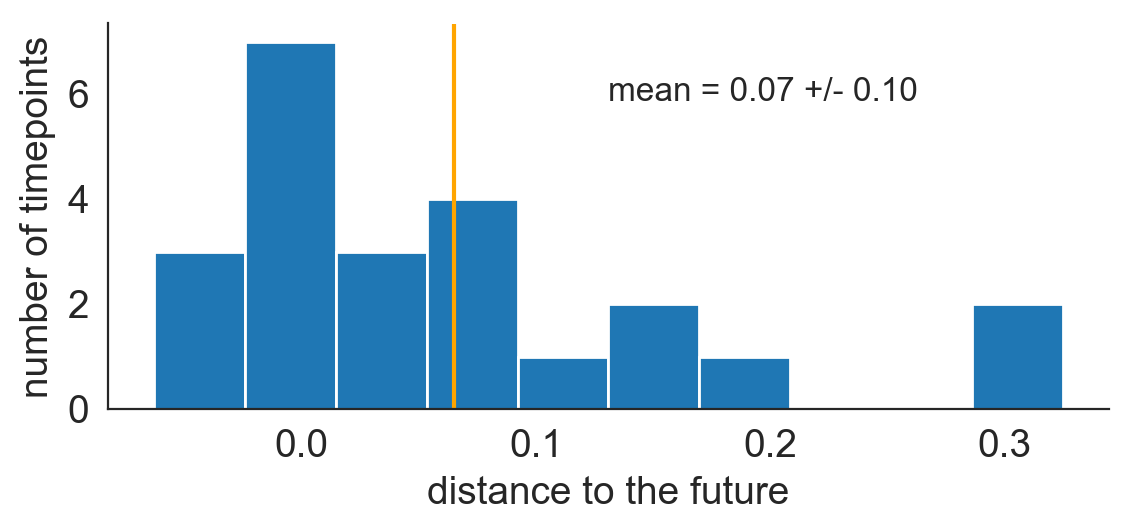

In [182]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[simulated_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_simulated_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

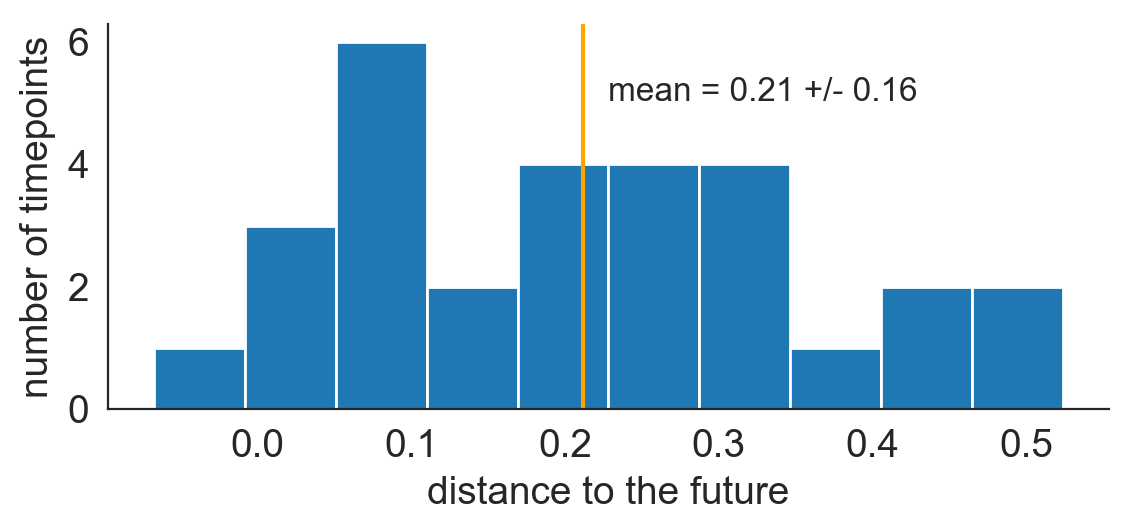

In [183]:
naive_natural_errors_by_time_df = natural_errors_by_time_df[natural_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_natural_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [184]:
total_simulated_timepoints = simulated_errors_by_time_df.loc[
    simulated_errors_by_time_df["predictors"] == "normalized_fitness",
    "validation_error"
].shape[0]
total_simulated_timepoints

23

In [185]:
true_fitness_accuracy = (
    simulated_errors_by_time_df.loc[simulated_errors_by_time_df["predictors"] == "normalized_fitness", "validation_error"] <= 0
).sum()
true_fitness_accuracy

21

In [186]:
true_fitness_accuracy / float(total_simulated_timepoints)

0.9130434782608695

In [187]:
simulated_naive_accuracy = (
    simulated_errors_by_time_df.loc[simulated_errors_by_time_df["predictors"] == "naive", "validation_error"] <= 0
).sum()
simulated_naive_accuracy

6

In [188]:
simulated_naive_accuracy / float(total_simulated_timepoints)

0.2608695652173913

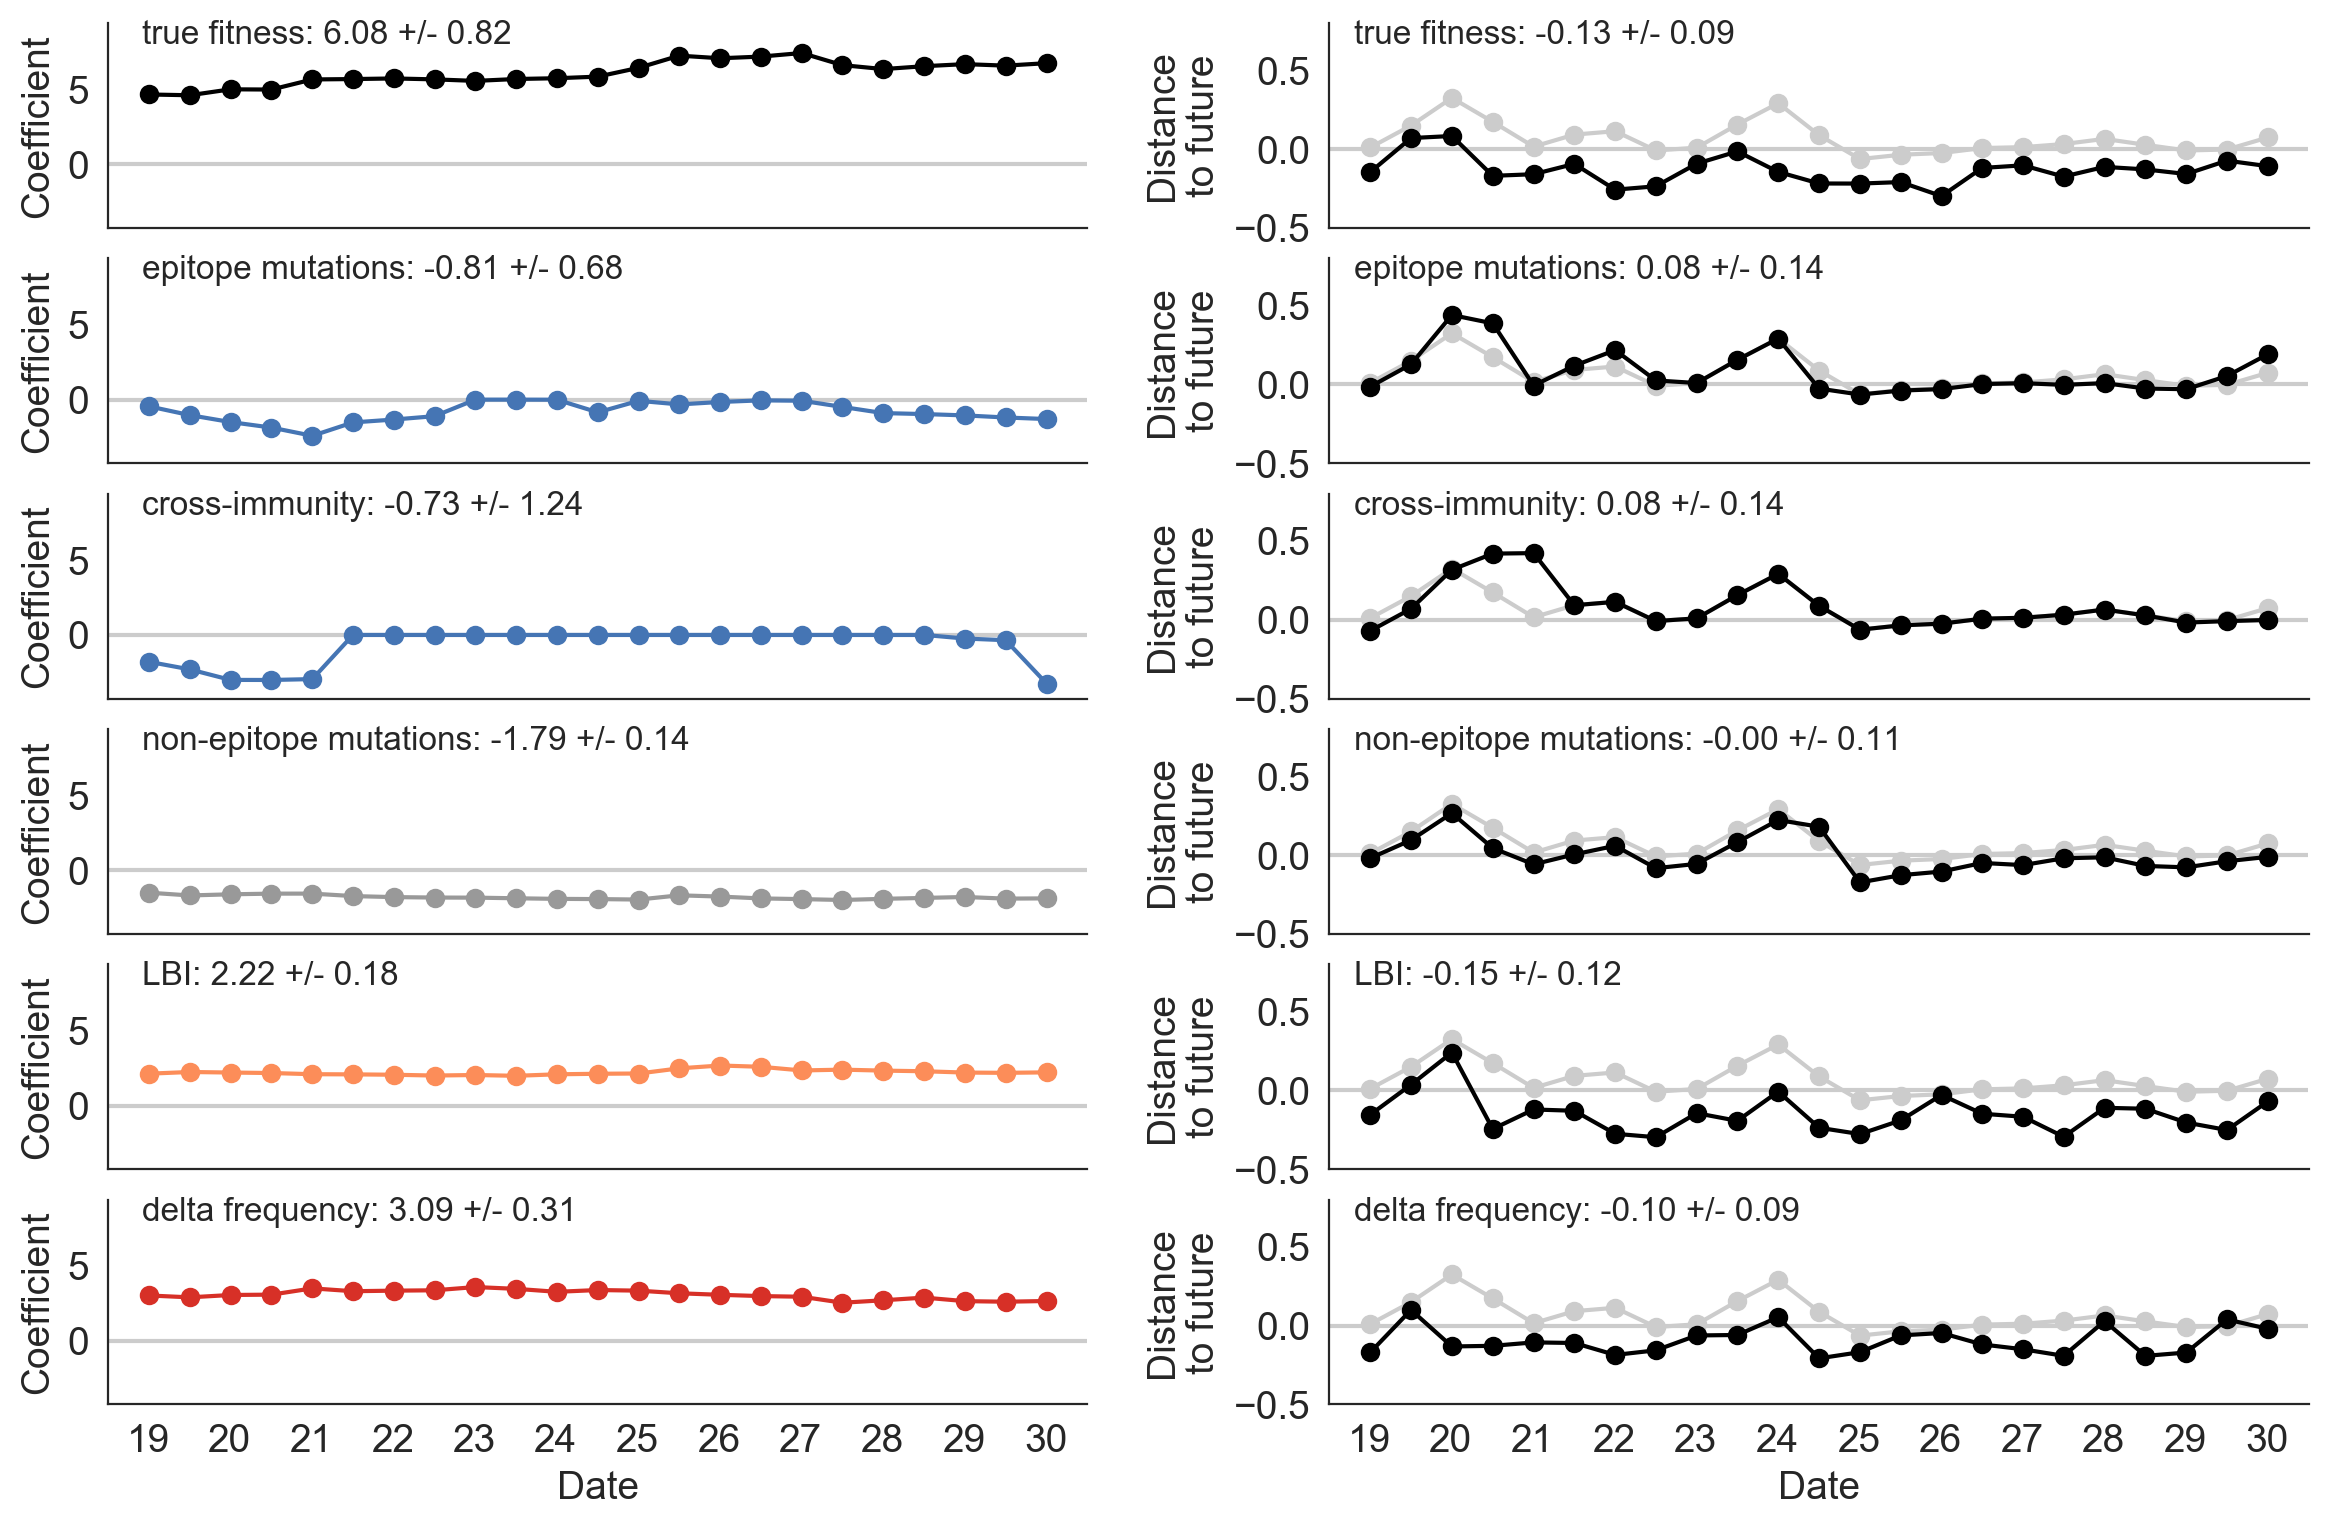

In [189]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=8,
    hspace=0.1
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

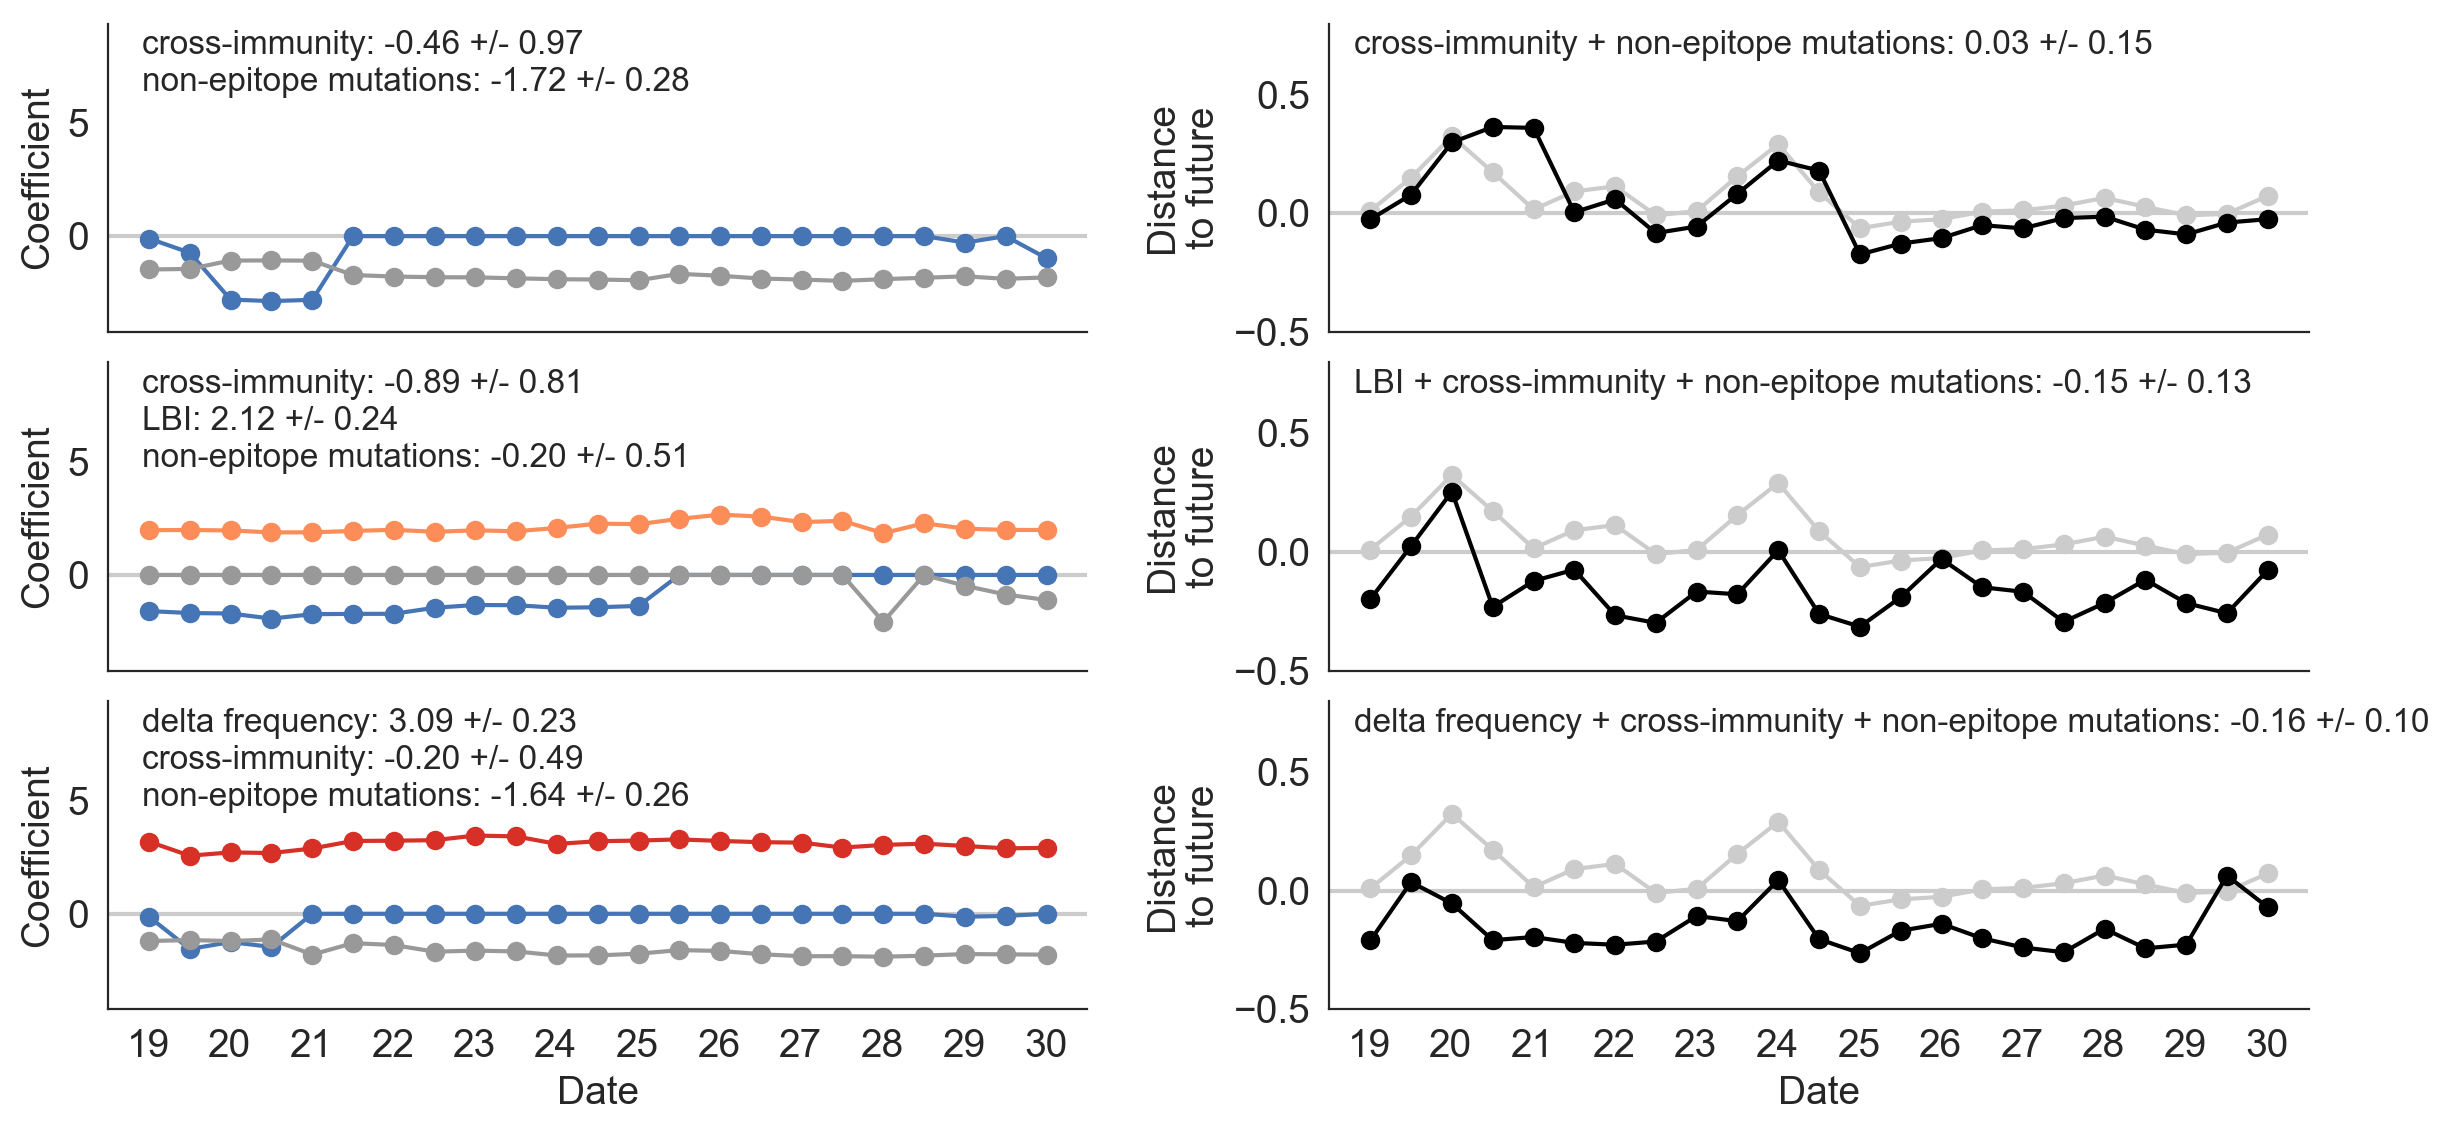

In [190]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [196]:
natural_errors_by_time_df.tail()

predictors  validation_error  validation_n  \
1037  delta_frequency-cTiter_x-ne_star          0.194044           771   
1038  delta_frequency-cTiter_x-ne_star         -0.237299           718   
1039  delta_frequency-cTiter_x-ne_star         -0.180848           683   
1040  delta_frequency-cTiter_x-ne_star          0.030620           878   
1041  delta_frequency-cTiter_x-ne_star          0.101858           976   

     validation_timepoint     type                                sample  
1037           2012-10-01  natural  natural_sample_0_with_90_vpm_sliding  
1038           2013-04-01  natural  natural_sample_0_with_90_vpm_sliding  
1039           2013-10-01  natural  natural_sample_0_with_90_vpm_sliding  
1040           2014-04-01  natural  natural_sample_0_with_90_vpm_sliding  
1041           2014-10-01  natural  natural_sample_0_with_90_vpm_sliding

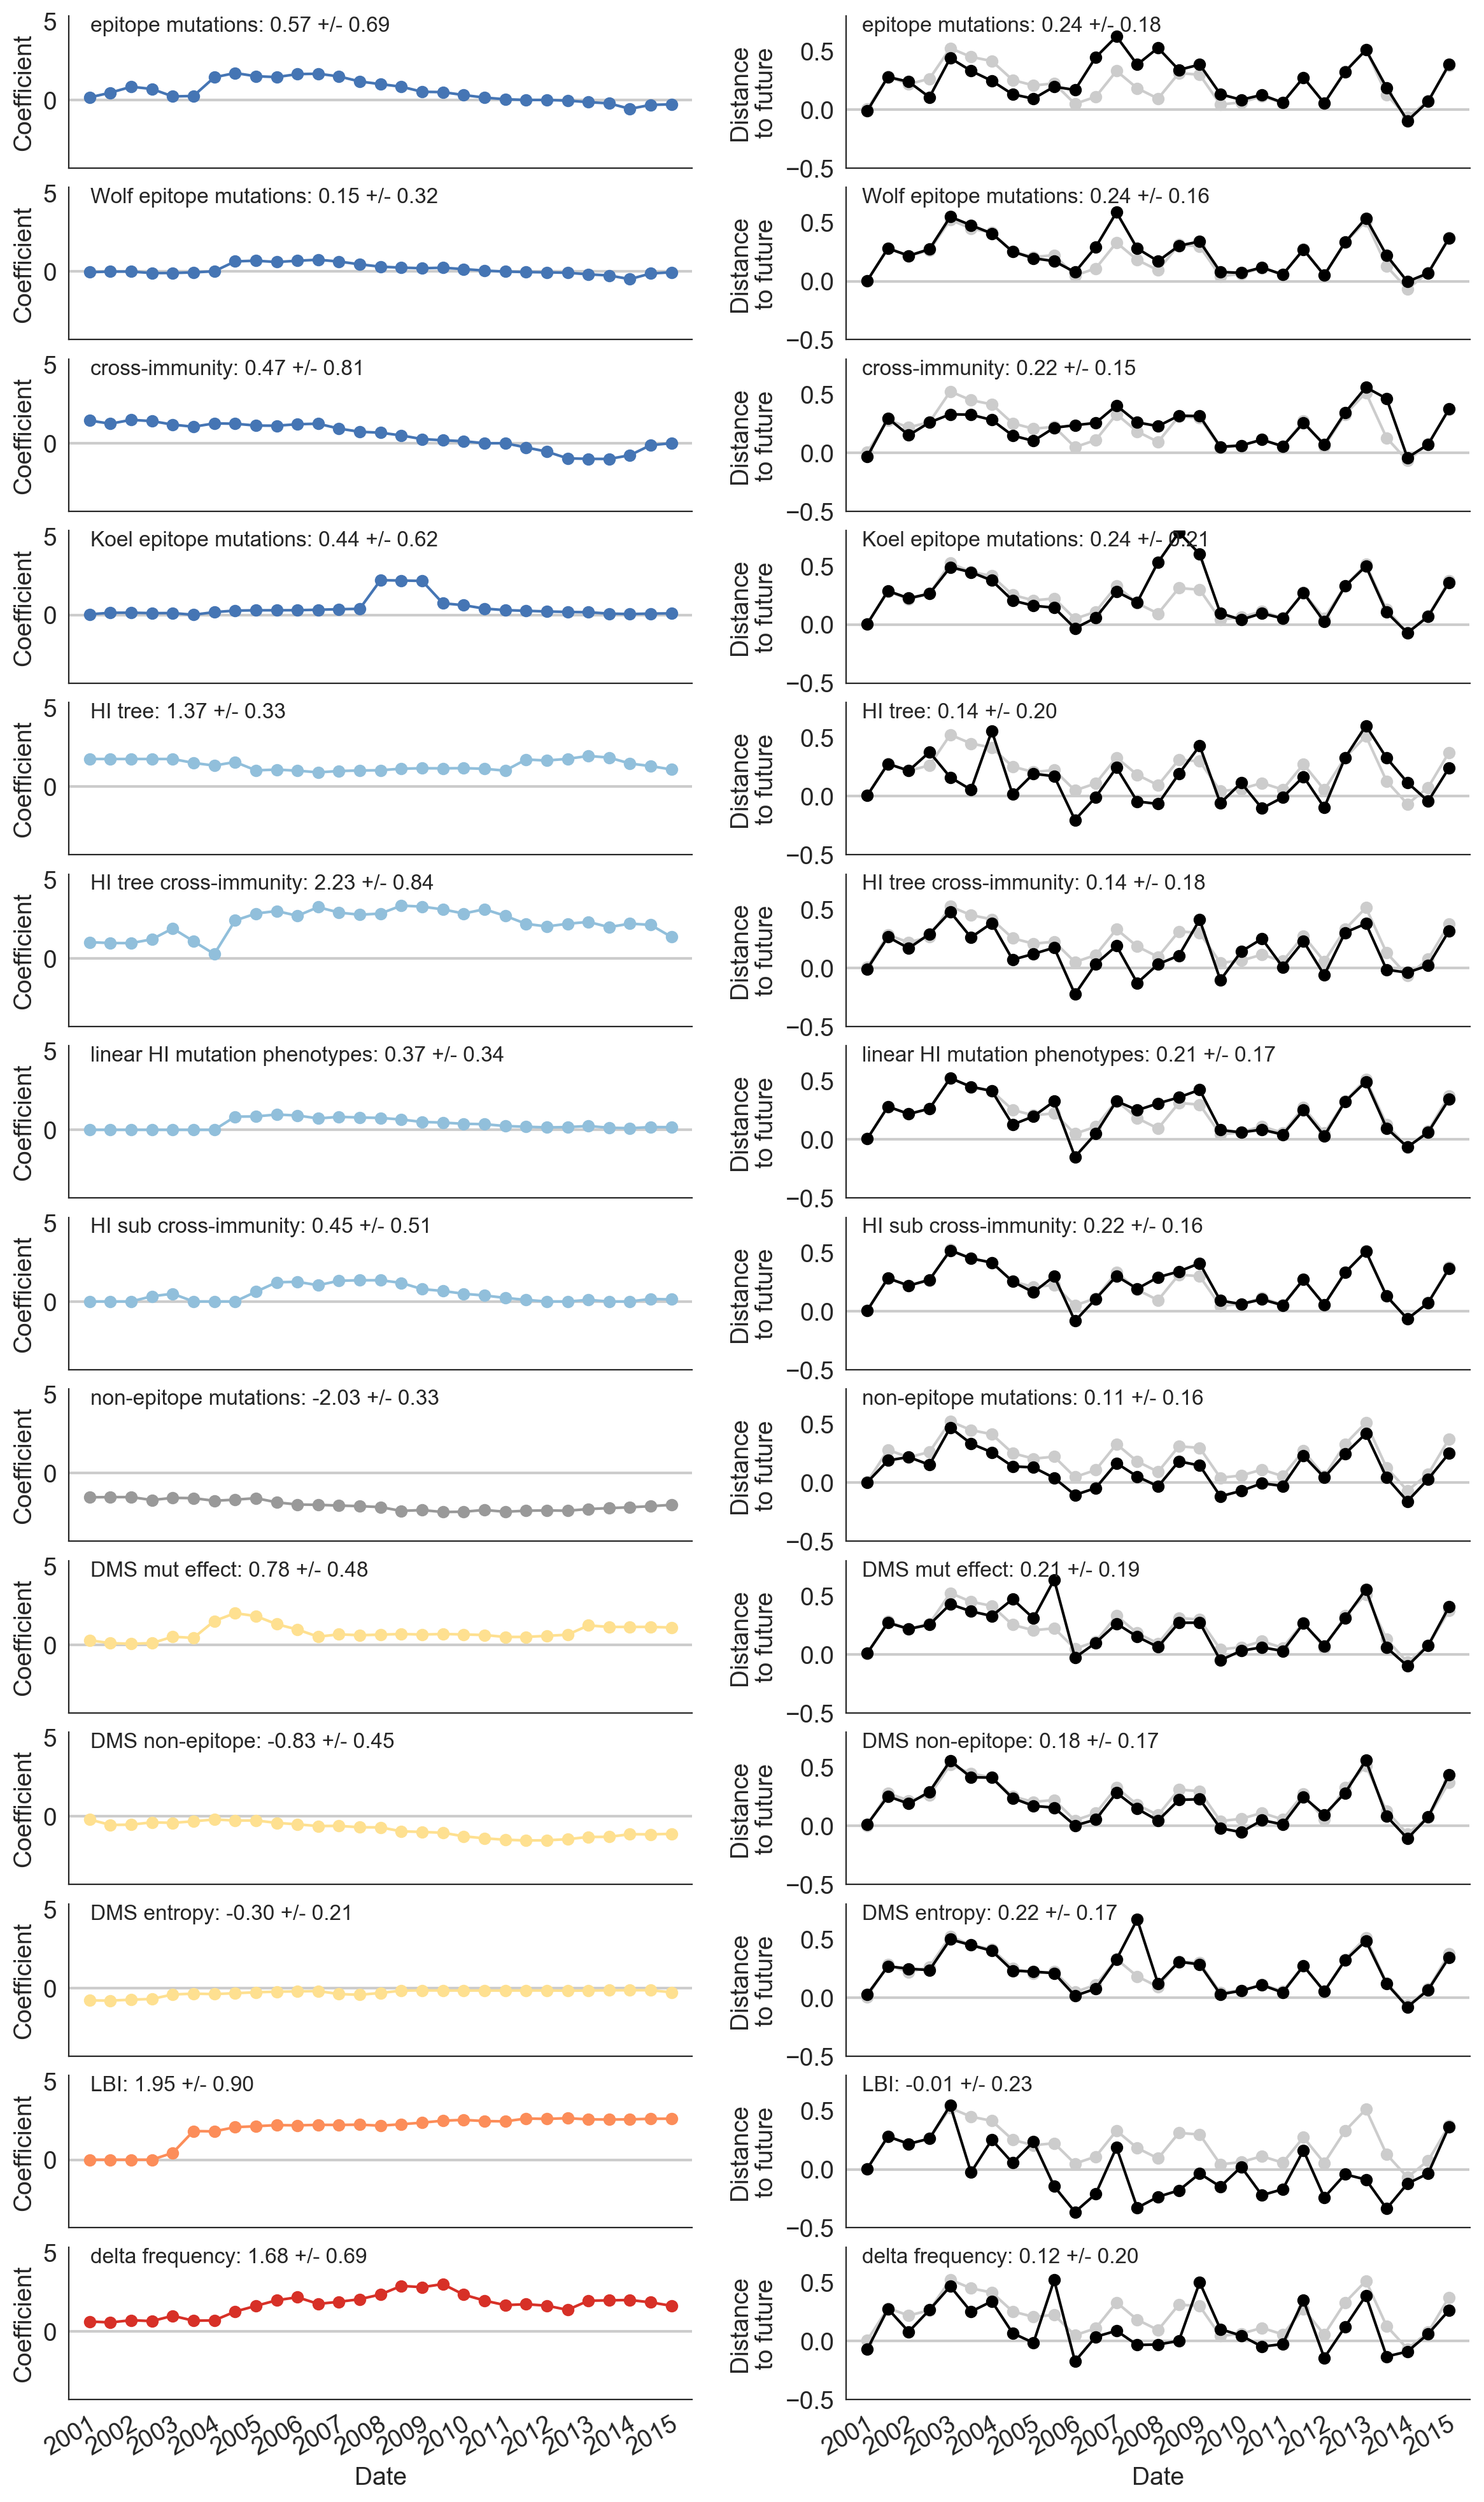

In [197]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

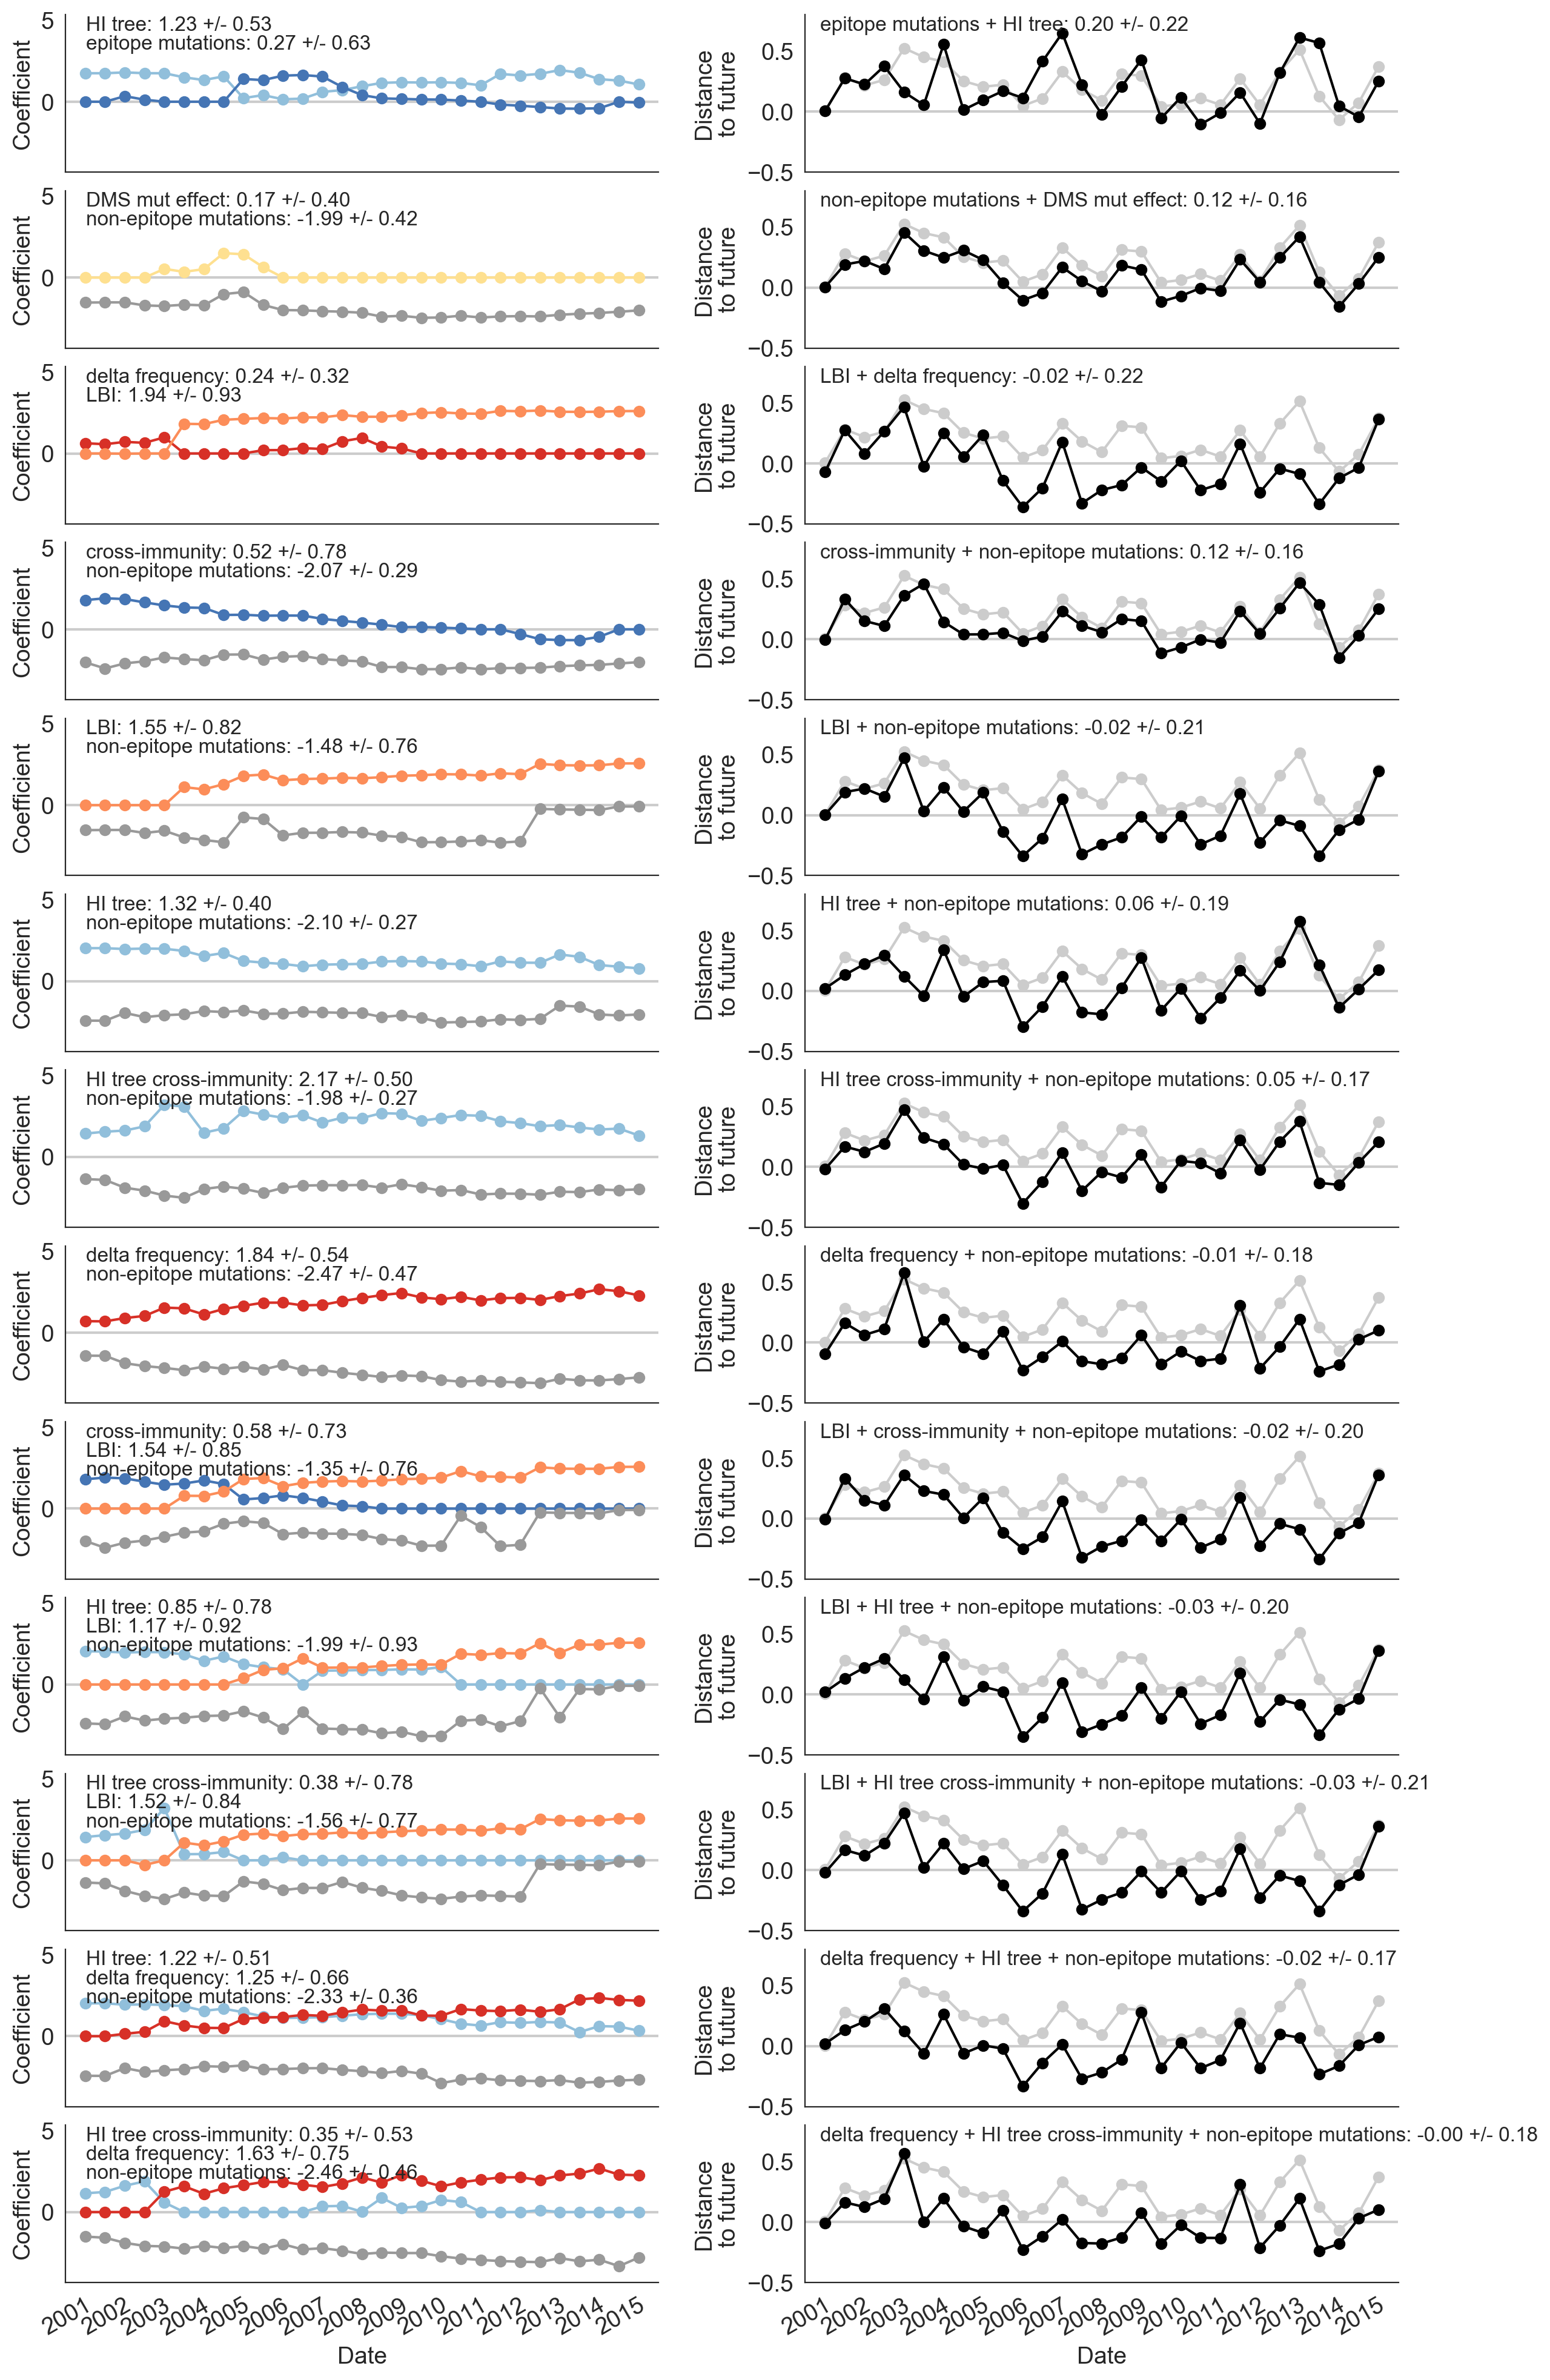

In [198]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

In [199]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

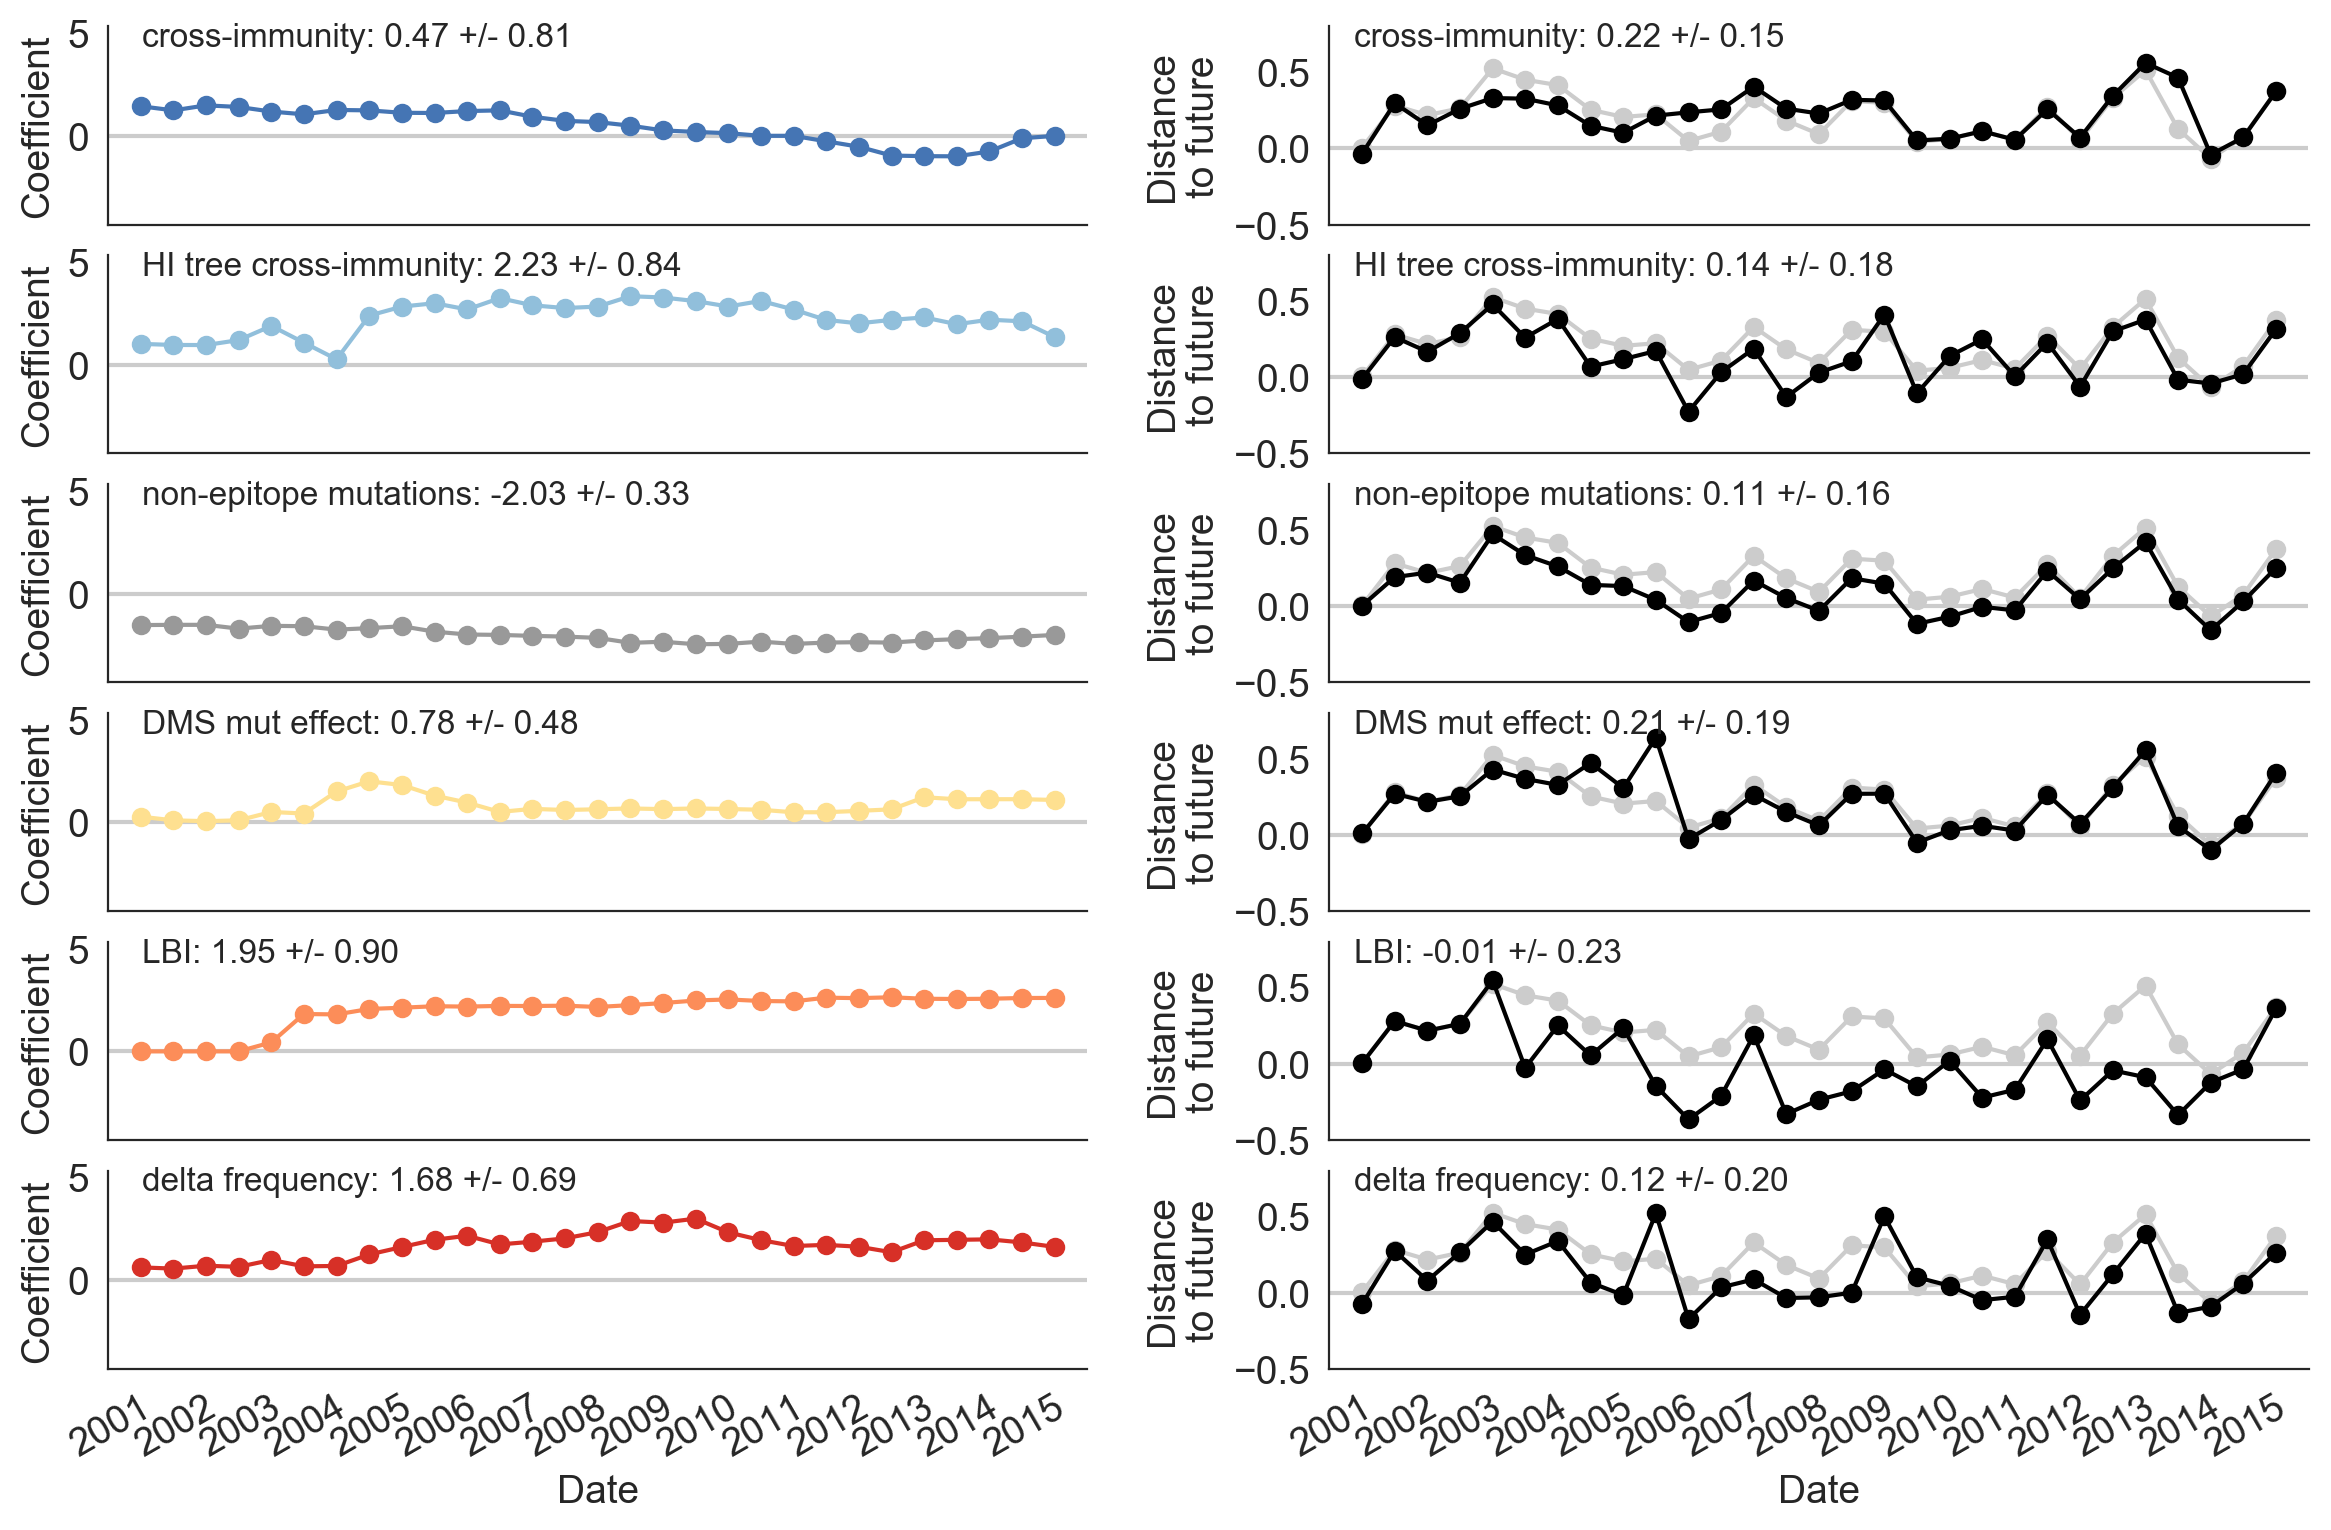

In [200]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=8
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [201]:
cross_immunity_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "ep_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
cross_immunity_better_than_naive

11

In [202]:
titers_better_than_naive = (natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"
].values < natural_errors_by_time_df.loc[
    natural_errors_by_time_df["predictors"] == "naive", "validation_error"
].values).sum()
titers_better_than_naive

24

In [206]:
total_timepoints = natural_errors_by_time_df.loc[natural_errors_by_time_df["predictors"] == "cTiter_x", "validation_error"].values.shape[0]

In [207]:
titers_better_than_naive / float(total_timepoints)

0.8275862068965517

In [208]:
cross_immunity_better_than_naive / float(total_timepoints)

0.3793103448275862

### Within category model comparisons

#### Antigenic

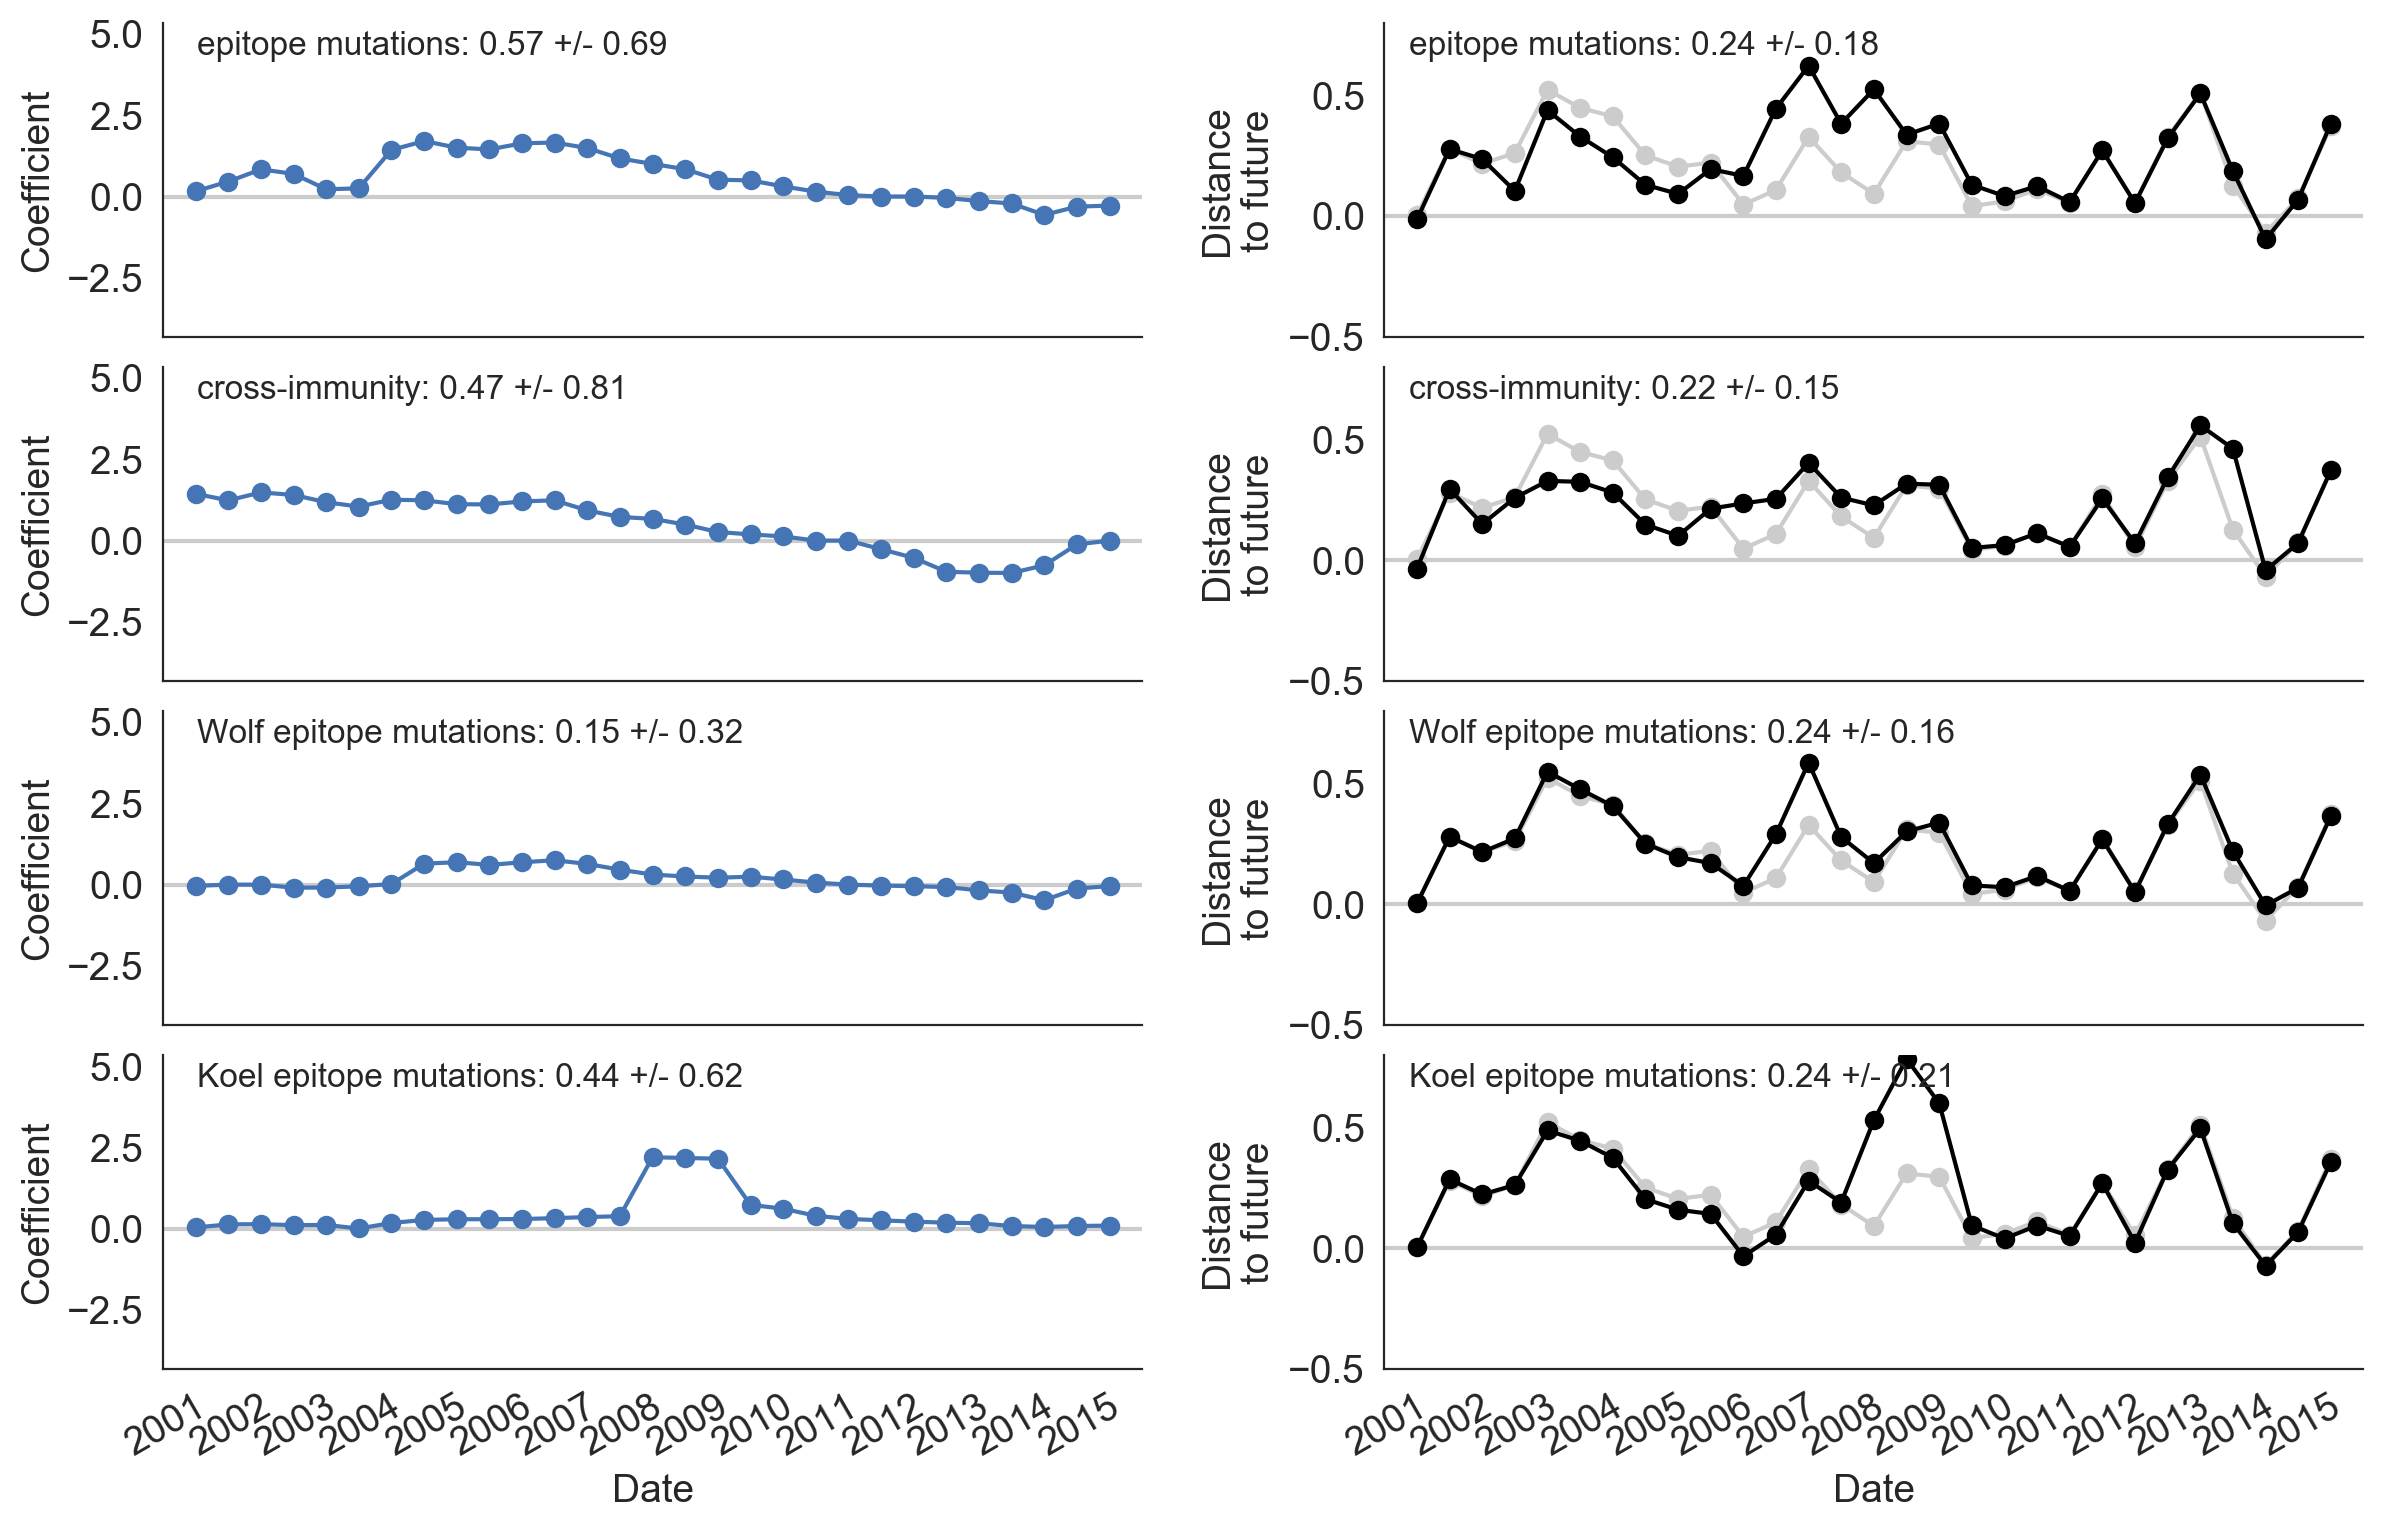

In [209]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8
)

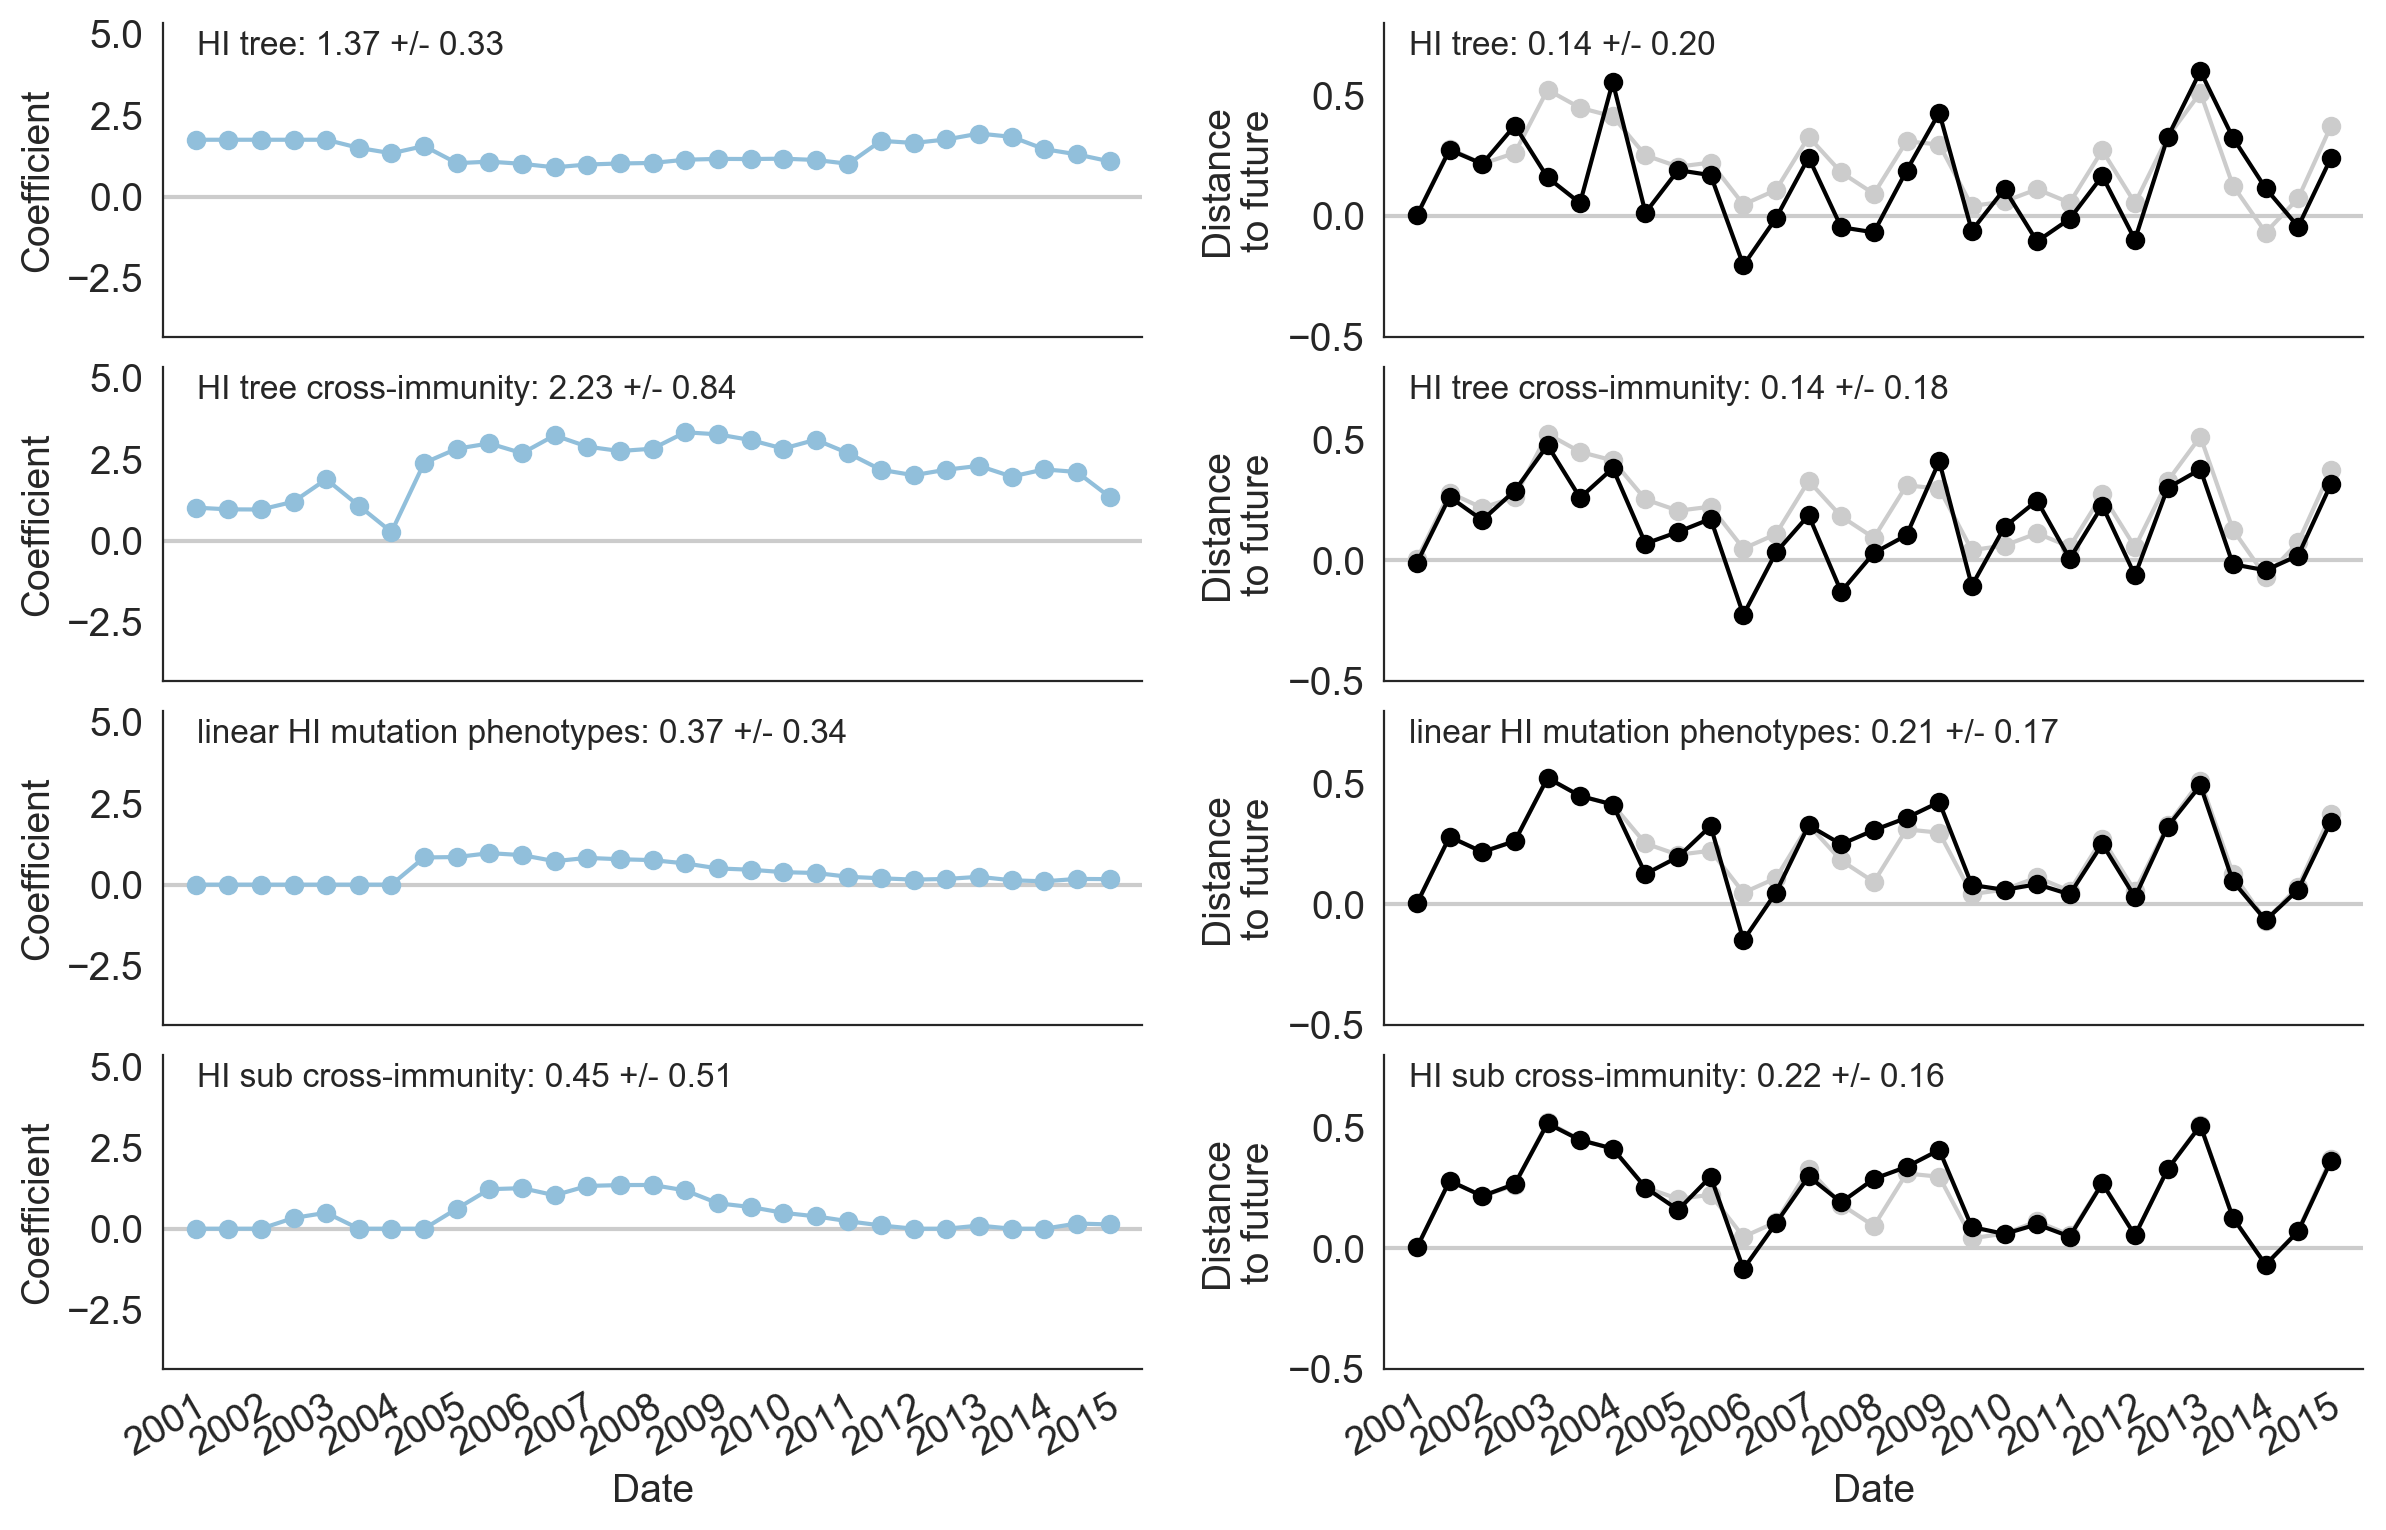

In [210]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8
)

#### Functional

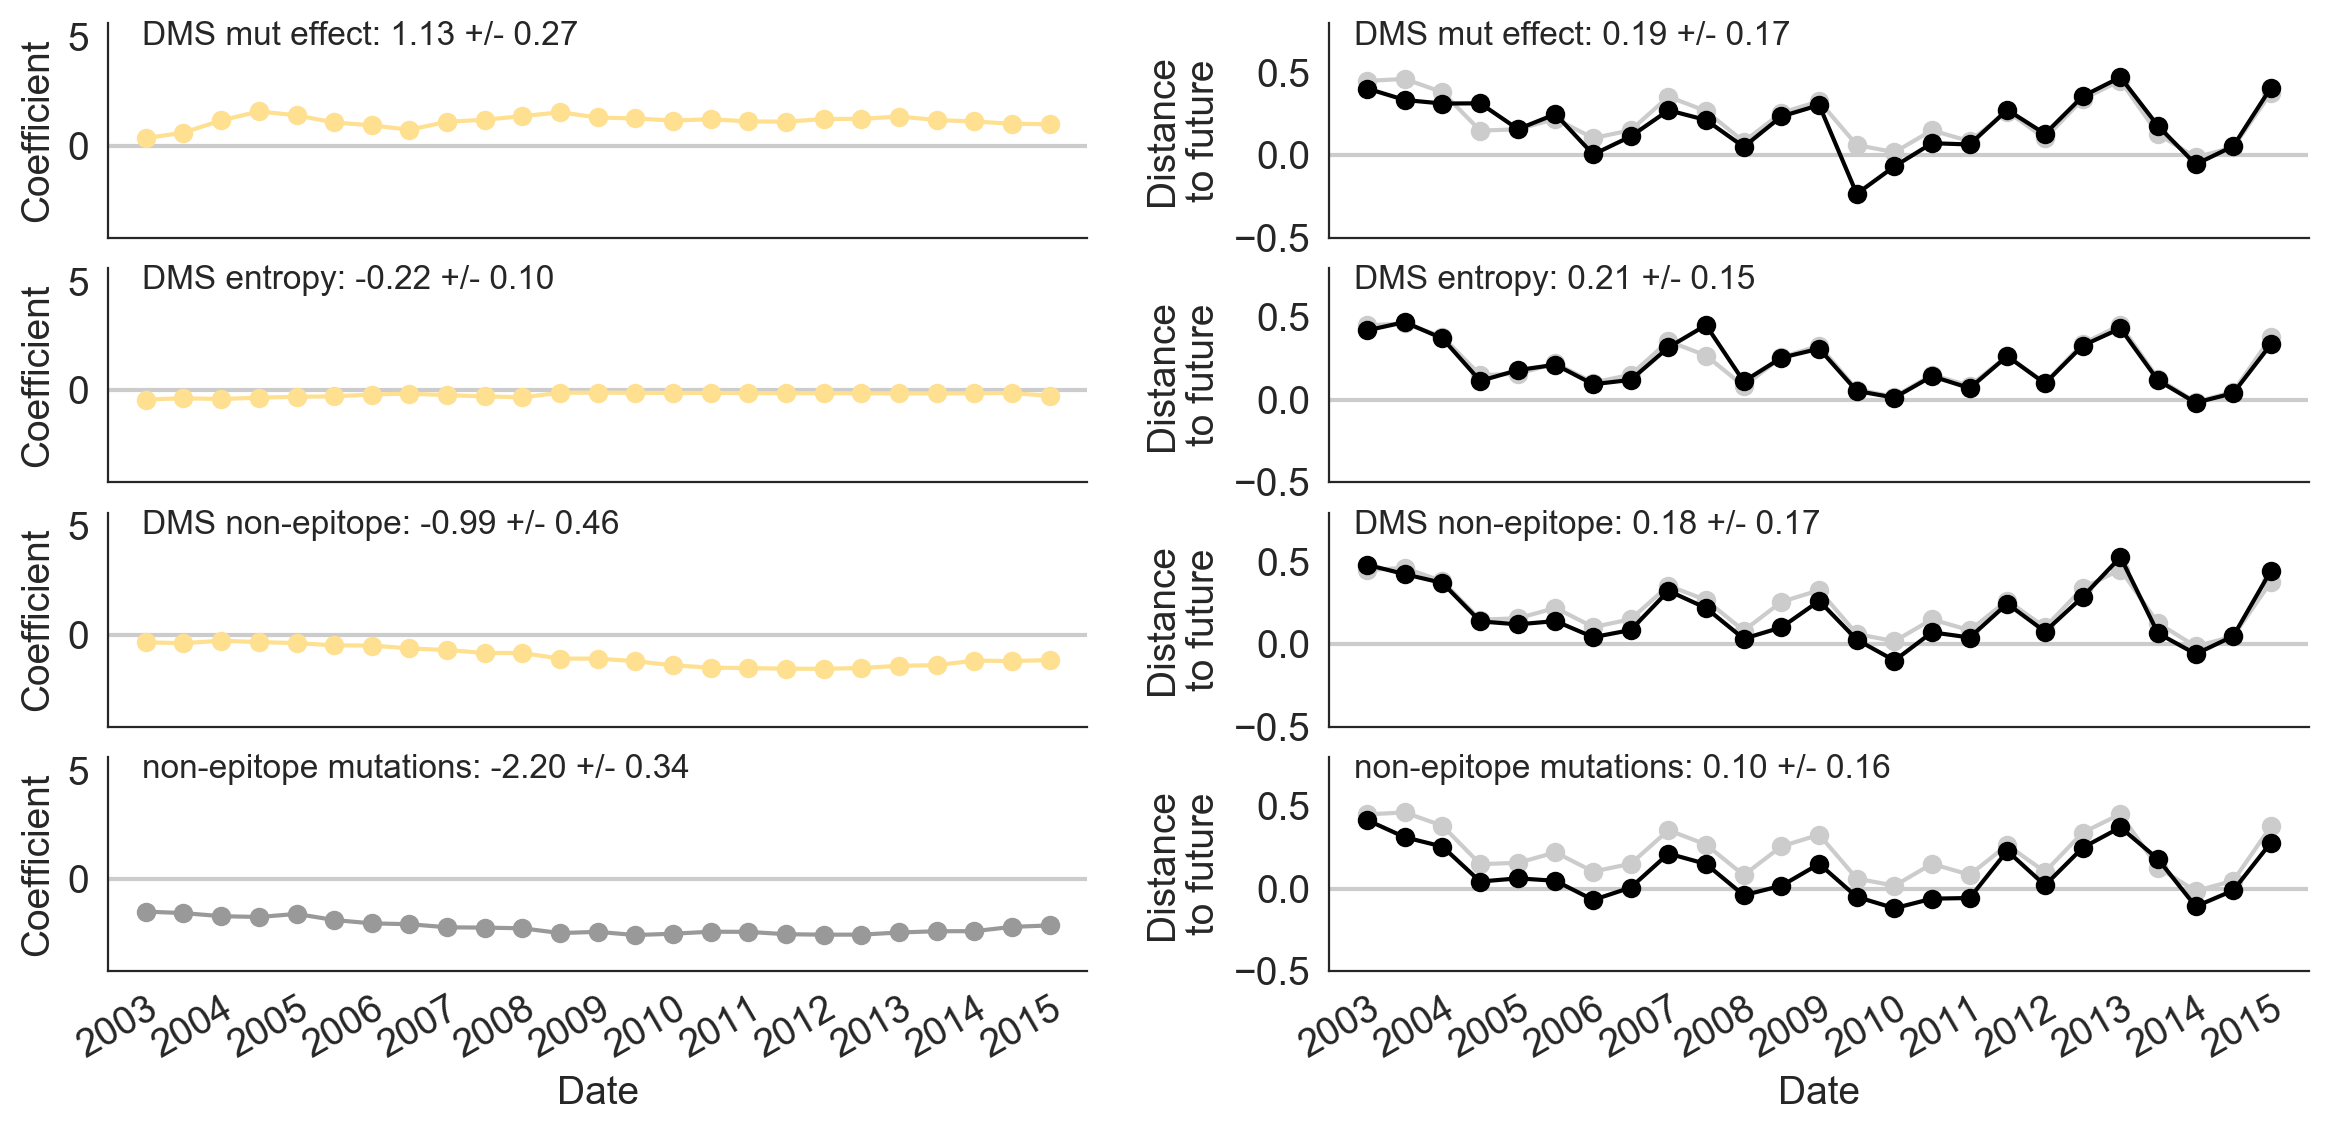

In [116]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=6
)

#### All categories

In [118]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

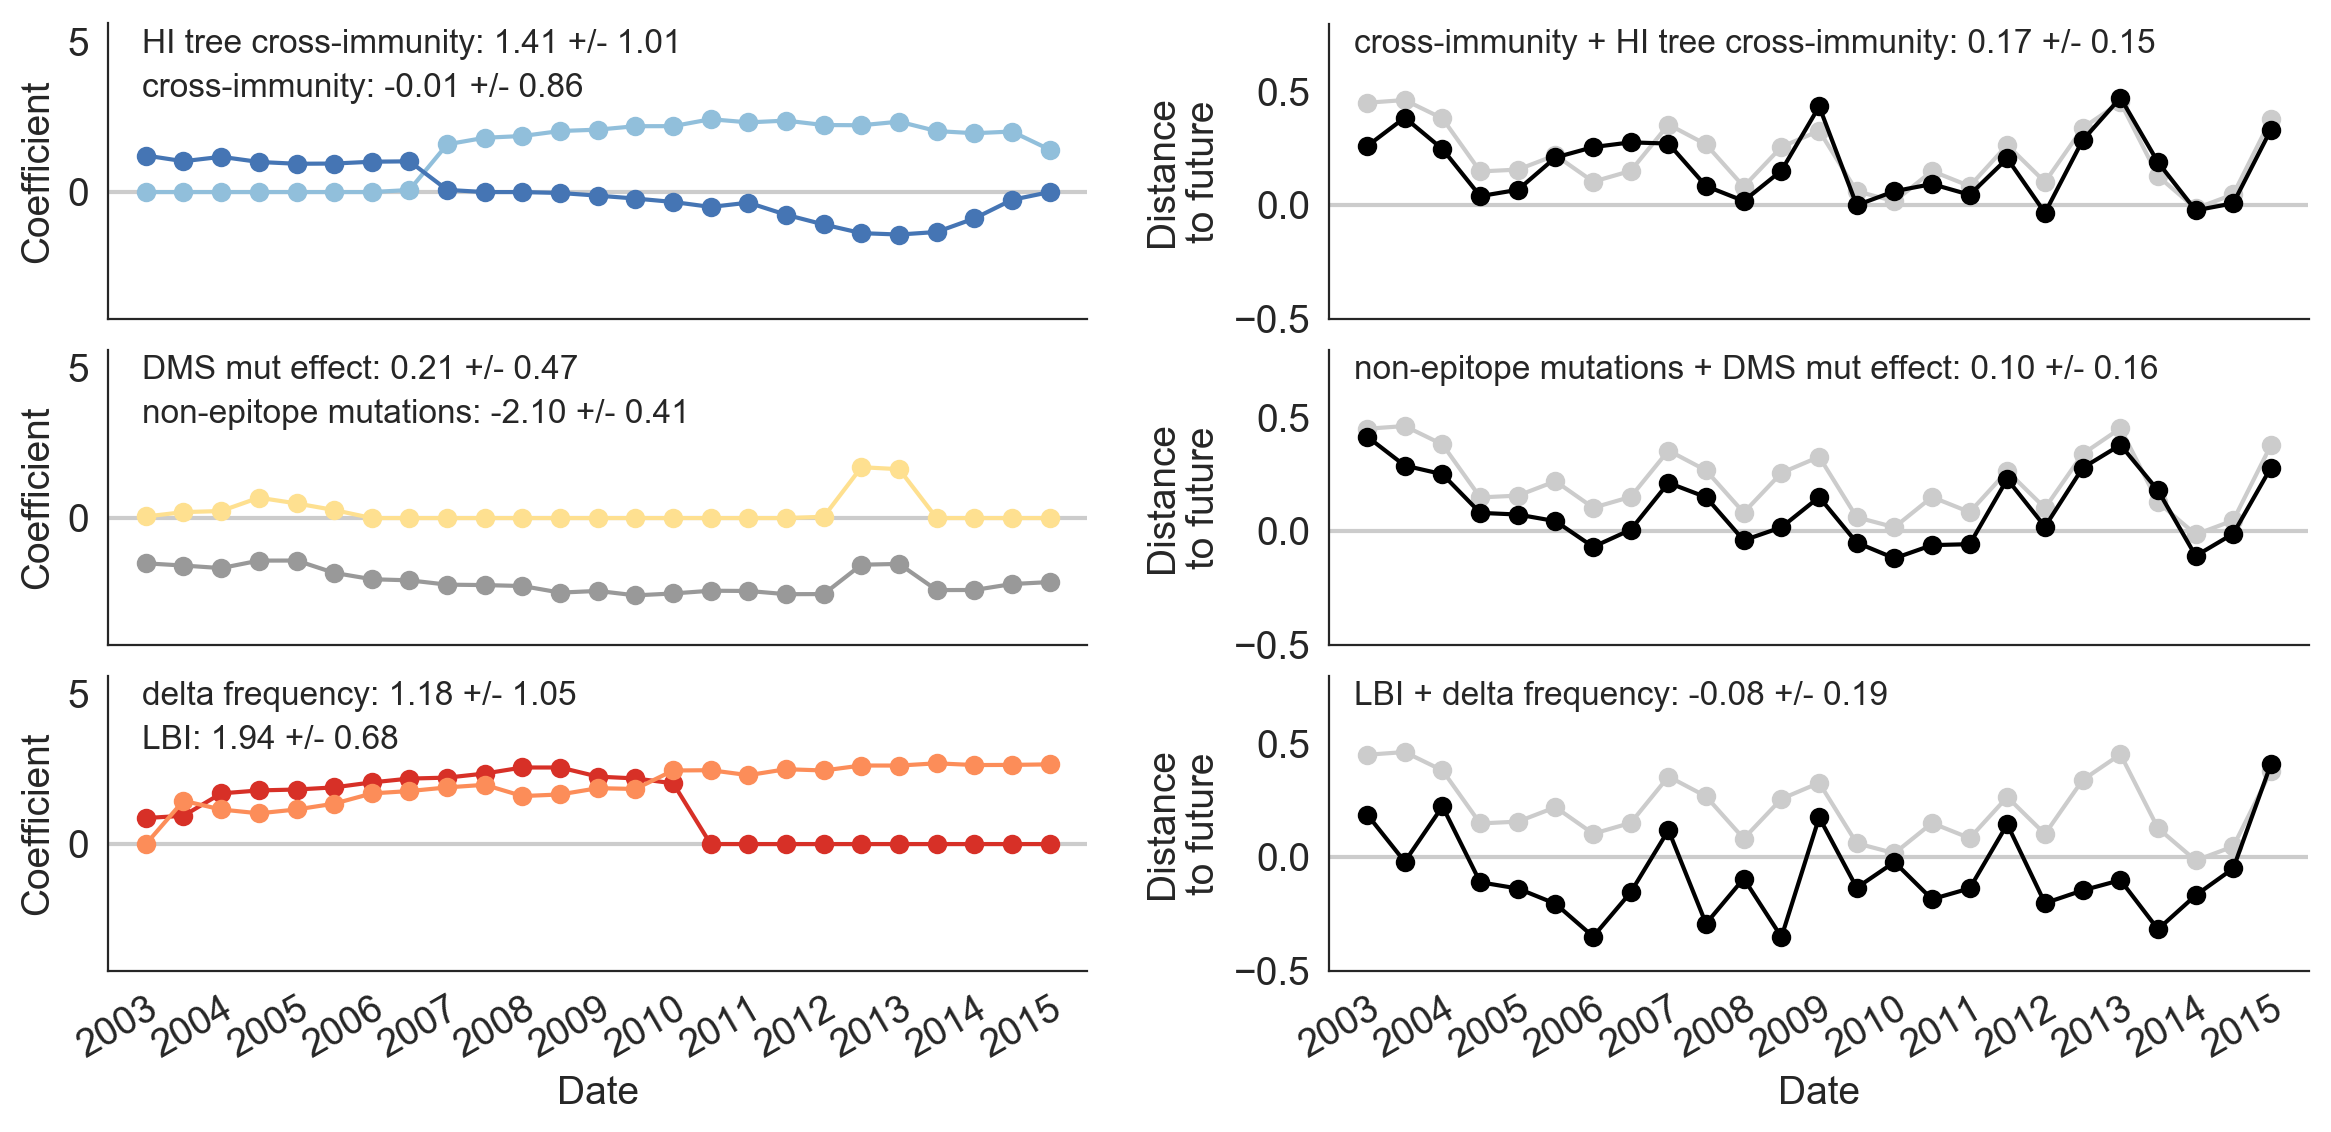

In [119]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best composite model

In [211]:
best_model = [
    "cTiter_x-ne_star",
    "lbi-ne_star",
    "delta_frequency-ne_star",
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

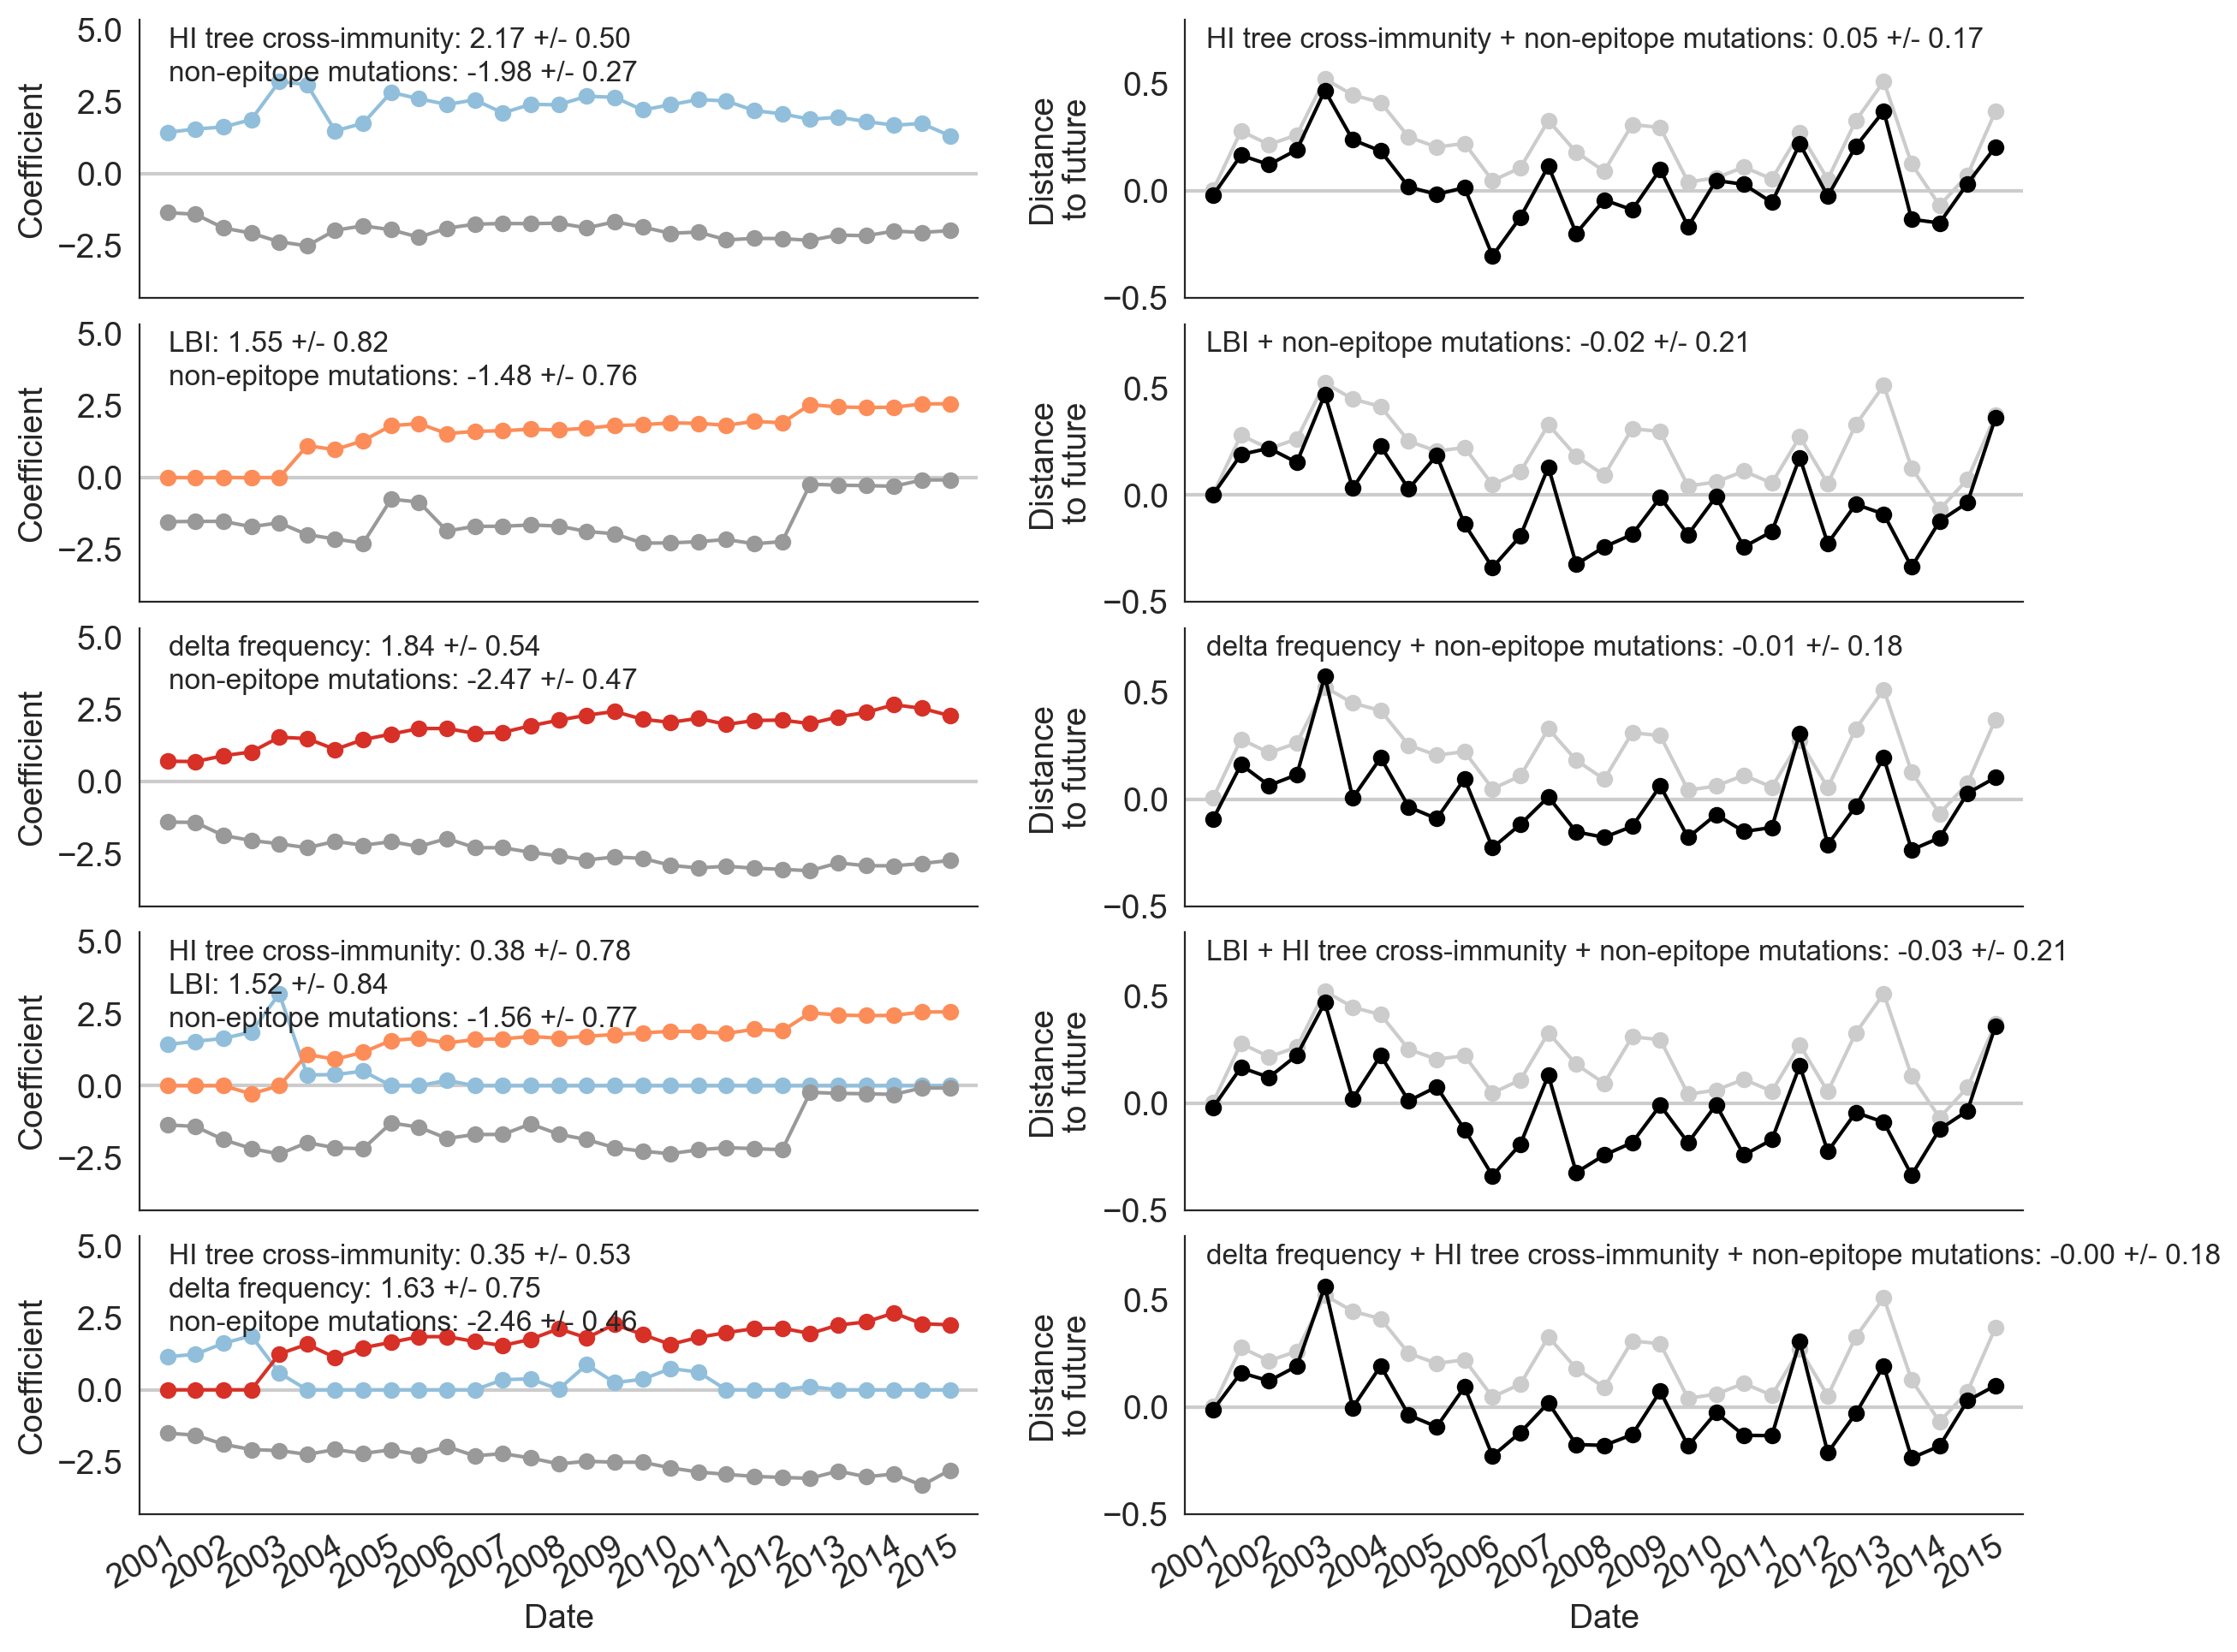

In [212]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_model,
    height=10,
    text_vertical_padding=0.12
)
plt.savefig("../manuscript/figures/best-unadjusted-model-accuracy-and-coefficients-for-natural-populations.pdf")

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")